In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Setup environment

In [2]:
# Verifica e instala MONAI, matplotlib y torch si es necesario
!python -c "import monai" || pip install -q "monai[all]"  # Instala la versión completa de MONAI, que incluye dependencias
!python -c "import torch" || pip install -q torch         # Verifica si torch está instalado, e instálalo si no lo está
!python -c "import matplotlib" || pip install -q matplotlib

%matplotlib inline

2025-01-08 09:41:32.767212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736329292.787502 3154367 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736329292.793835 3154367 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import monai
print(dir(monai.networks.nets))
print(monai.__version__)

/mnt/nfs/home/liglesias/anaconda3/envs/cardio/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-08 09:41:51.811098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736329311.832771 3151069 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736329311.838873 3151069 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['AHNet', 'AHnet', 'Ahnet', 'AttentionUnet', 'AutoEncoder', 'AutoencoderKL', 'BasicUNet', 'BasicUNetPlusPlus', 'BasicUnet', 'BasicUnetPlusPlus', 'Basicunet', 'BasicunetPlusPlus', 'BertAttention', 'BertMixedLayer', 'BertOutput', 'BertPreTrainedModel', 'BlockArgs', 'Classifier', 'ControlNet', 'Critic', 'DAF3D', 'DecoderOnlyTransformer', 'DenseNet', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'DenseNet264', 'Densenet', 'Densenet121', 'Densenet169', 'Densenet201', 'Densenet264', 'DiNTS', 'DiffusionModelUNet', 'Discriminator', 'DynUNet', 'DynUnet', 'Dynunet', 'EfficientNet', 'EfficientNetBN', 'EfficientNetBNFeatures', 'EfficientNetEncoder', 'FLEXUNET_BACKBONE', 'FlexUNet', 'FlexUNetEncoderRegister', 'FlexibleUNet', 'FullyConnectedNet', 'Generator', 'GlobalNet', 'HighResBlock', 'HighResNet', 'HoVerNet', 'HoVernet', 'HoverNet', 'Hovernet', 'LocalNet', 'MILModel', 'MedNeXt', 'MedNeXtB', 'MedNeXtL', 'MedNeXtLarge', 'MedNeXtM', 'MedNeXtMedium', 'MedNeXtS', 'MedNeXtSmall', 'MedNext', 'MedNextB',

## Setup imports

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import nibabel as nib
from nibabel.orientations import axcodes2ornt, ornt_transform
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import Dataset, DataLoader
from monai.networks.layers import Act
from monai.utils import first, set_determinism
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged
#from torch.amp import autocast
#from torch.cuda.amp import autocast
from torch.amp import autocast
from monai.networks.nets import AutoencoderKL, PatchDiscriminator
# from generative.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.utils.misc import ensure_tuple
print_config()

MONAI version: 1.5.dev2447
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 2d6751b01bf78fddabe03b2c53645c6bc9808ed8
MONAI __file__: /mnt/nfs/home/<username>/anaconda3/envs/cardio/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.1
lmdb version: 1.5.1
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.18.0
pynrrd version: 1.1.1
clearml version: 1.16.5

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
#root_dir = r"C:/Users/Lucia/Desktop/MÁSTER/TFM_Data/database"
#root_dir = '/mnt/nfs/home/liglesias/data_tgv'
#root_dir = '//atlas.bit.upm.es/BIT-UPM-projects/CARDIO-HULP/SCRATCH_STUDENTS/liglesias/data_acdc'

root_dir = '/mnt/nfs/home/liglesias/data_acdc'

training_dir = os.path.join(root_dir, "masks_training")
testing_dir = os.path.join(root_dir, "masks_testing")
training_dir_noise = os.path.join(root_dir, "masks_training_noise")
testing_dir_noise = os.path.join(root_dir, "masks_testing_noise")
training_dir_elongated = os.path.join(root_dir, "masks_training_noise_2")
testing_dir_elongated = os.path.join(root_dir, "masks_testing_noise_2")

assert os.path.exists(training_dir), f"El directorio {training_dir} no existe"
assert os.path.exists(testing_dir), f"El directorio {testing_dir} no existe"
assert os.path.exists(training_dir_noise), f"El directorio {training_dir_noise} no existe"
assert os.path.exists(testing_dir_noise), f"El directorio {testing_dir_noise} no existe"
assert os.path.exists(training_dir_elongated), f"El directorio {training_dir_elongated} no existe"
assert os.path.exists(testing_dir_elongated), f"El directorio {testing_dir_elongated} no existe"

def list_nifti_files(directory):
    nifti_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".nii") or file.endswith(".nii.gz"):
                nifti_files.append(os.path.join(root, file))
    return nifti_files

training_files = list_nifti_files(training_dir)
testing_files = list_nifti_files(testing_dir)
training_files_noise = list_nifti_files(training_dir_noise)
testing_files_noise = list_nifti_files(testing_dir_noise)
training_files_elongated = list_nifti_files(training_dir_elongated)
testing_files_elongated = list_nifti_files(testing_dir_elongated)

print(f"Se encontraron {len(training_files)} archivos en {training_dir}")
print(f"Se encontraron {len(testing_files)} archivos en {testing_dir}")
print(f"Se encontraron {len(training_files_noise)} archivos en {training_files_noise}")
print(f"Se encontraron {len(testing_files_noise)} archivos en {testing_dir_noise}")
print(f"Se encontraron {len(training_files_noise)} archivos en {training_files_elongated}")
print(f"Se encontraron {len(testing_files_noise)} archivos en {testing_files_elongated}")

Se encontraron 200 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_training
Se encontraron 100 archivos en /mnt/nfs/home/liglesias/data_acdc/masks_testing
Se encontraron 200 archivos en ['/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient001_frame12_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient002_frame12_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient003_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient004_frame15_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient005_frame13_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient006_frame16_gt.nii.gz', '/mnt/nfs/home/liglesias/data_acdc/masks_training_noise/patient007_frame01_gt.nii.gz', '/mnt/nfs/home/liglesias/d

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


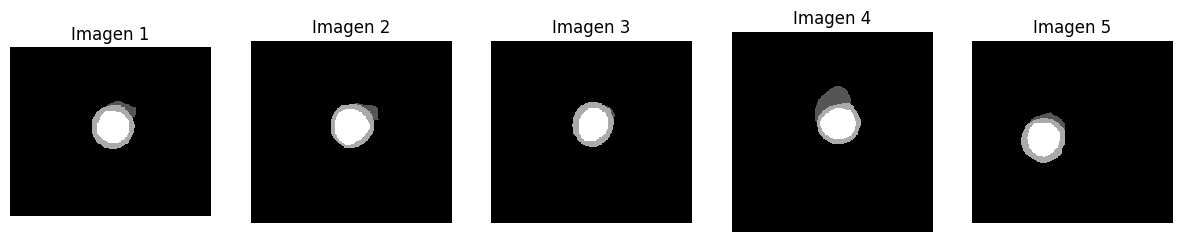

In [6]:
images = [nib.load(file).get_fdata() for file in training_files[:5]] 
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, img in enumerate(images):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

(216, 256, 10)
(232, 256, 10)
(232, 256, 10)
(256, 256, 10)
(232, 256, 10)


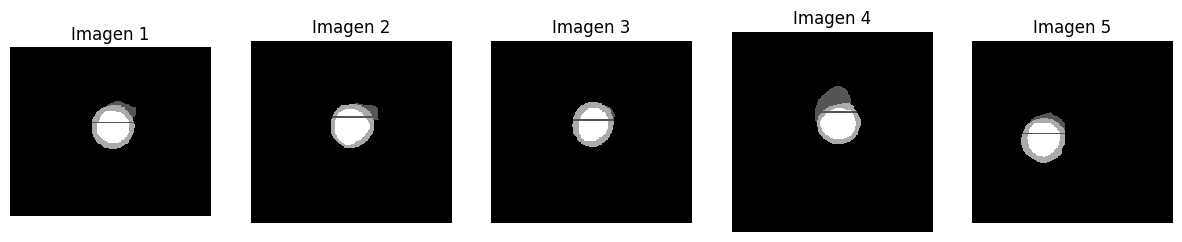

In [7]:
images_noise = [nib.load(file).get_fdata() for file in training_files_noise[:5]] 
fig, axs = plt.subplots(1, len(images_noise), figsize=(15, 5))

for i, img in enumerate(images_noise):
    axs[i].imshow(img[:, :, img.shape[2] // 2], cmap="gray", interpolation='none') 
    axs[i].axis("off") 
    axs[i].set_title(f"Imagen {i+1}")
    print(img.shape)
plt.show()

In [8]:
all_files = training_files + testing_files
all_files_noise = training_files_noise + testing_files_noise

images = [nib.load(file).get_fdata() for file in all_files]
images_noise = [nib.load(file).get_fdata() for file in all_files_noise]
image_shapes = [img.shape for img in images]
image_shapes_noise = [img.shape for img in images_noise]
print(image_shapes)
print(image_shapes_noise)
average_shape = np.mean(image_shapes, axis=0).astype(int)
average_shape_noise = np.mean(image_shapes_noise, axis=0).astype(int)
print(f"Tamaño promedio: {average_shape}")
print(f"Tamaño promedio de las imágenes con ruido: {average_shape_noise}")
min_shape = np.min(image_shapes, axis=0)
max_shape = np.max(image_shapes, axis=0)
min_shape_noise = np.min(image_shapes_noise, axis=0)
max_shape_noise = np.max(image_shapes_noise, axis=0)

print(f"Tamaño mínimo: {min_shape}")
print(f"Tamaño máximo: {max_shape}")
print(f"Tamaño mínimo: {min_shape_noise}")
print(f"Tamaño máximo: {max_shape_noise}")

[(216, 256, 10), (232, 256, 10), (232, 256, 10), (256, 256, 10), (232, 256, 10), (256, 216, 10), (256, 216, 10), (232, 256, 11), (222, 224, 10), (222, 224, 10), (200, 256, 10), (208, 256, 10), (208, 256, 10), (184, 256, 10), (184, 256, 10), (216, 256, 10), (256, 216, 10), (256, 216, 10), (256, 216, 9), (216, 256, 9), (216, 256, 8), (208, 256, 8), (200, 256, 7), (200, 256, 7), (216, 256, 9), (216, 256, 9), (208, 256, 8), (208, 256, 8), (256, 256, 9), (216, 256, 10), (216, 256, 10), (224, 256, 10), (216, 256, 10), (216, 256, 10), (216, 256, 10), (240, 256, 10), (216, 256, 10), (216, 256, 10), (224, 256, 10), (208, 256, 13), (216, 256, 8), (216, 256, 7), (276, 384, 8), (276, 384, 8), (208, 256, 9), (208, 256, 10), (154, 224, 6), (232, 256, 9), (208, 256, 8), (208, 256, 8), (256, 216, 9), (256, 208, 9), (256, 208, 9), (256, 216, 7), (224, 256, 10), (216, 256, 8), (216, 256, 7), (428, 512, 8), (216, 256, 9), (216, 256, 9), (256, 216, 9), (216, 256, 9), (216, 256, 9), (256, 216, 10), (210, 2

## Set deterministic training for reproducibility

In [9]:
# for reproducibility purposes set a seed
set_determinism(42)

## Description of data, download the training set and creation of dataloaders

The brain tumour segmentation dataset is available as part of the Decathlon dataset. Select the channel (MRI contrast) you wish to use for training (0: FLAIR, 1: T1, 2: T1-PC, 3: T2). 
Note: The DecatholonDataset has 7GB. So make sure that you have enought space when running the next line

We use the following transforms:
1. `LoadImaged`: retrieve the nii image
2. `EnsureChannelFirstd`: we ensure that the channel component is in dimension 0 of the tensor
3. `Lambdad`: this custom transform retrieves the specific channel that we desire
4. `EnsureChannelFirstd`: we add the new channel dimension (as the last transform has removed it)

In [10]:
from monai.data import NibabelReader
from monai.transforms import CastToTyped

In [11]:
# PREPARACIÓN DE LA IMAGEN MÉDICA
# Carga las imágenes y se asegura de que la imagen cargada tenga el canal de color en la primera dimensión
# Aplica una transformación personalizada a la imagen y garantiza que la imagen tenga el canal en la primera dimensión
# Asegura que tenga el tipo de datos adecuado, reorienta la imagen a un sist de coord específico
# Recorta la imagen a un tamaño específico y escala la intensidad de la imagen

resize_dim = (12, 128, 128)

all_transforms = [
    transforms.LoadImaged(keys=["image"]),
    transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    transforms.EnsureTyped(keys=["image"]),
    transforms.Orientationd(keys=["image"], axcodes="LPS"),
    # transforms.Orientationd(keys=["image"], axcodes="RAS"),
    transforms.Transposed(keys=["image"], indices=(0, 3, 2, 1)),
    transforms.AsDiscreted(keys=["image"], to_onehot=4),
    transforms.Resized(keys=["image"], spatial_size=resize_dim, mode=('nearest-exact')), 
]

In [12]:
train_data_dicts = [{"image": file} for file in training_files][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts)[0]['image'].shape

torch.Size([4, 12, 128, 128])

In [ ]:
train_data_dicts_noise = [{"image": file} for file in training_files_noise][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_noise)[0]['image'].shape

torch.Size([4, 12, 128, 128])

In [14]:
train_data_dicts_elongated = [{"image": file} for file in training_files_elongated][0:1]
transform = Compose(all_transforms)
transform(train_data_dicts_elongated)[0]['image'].shape

torch.Size([4, 12, 128, 128])

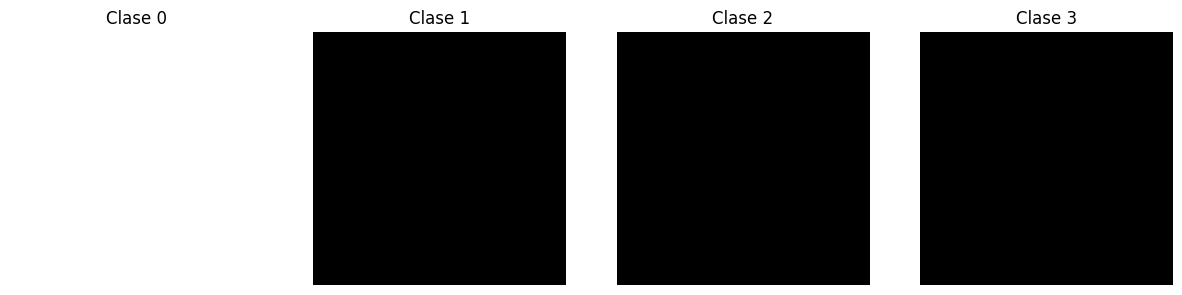

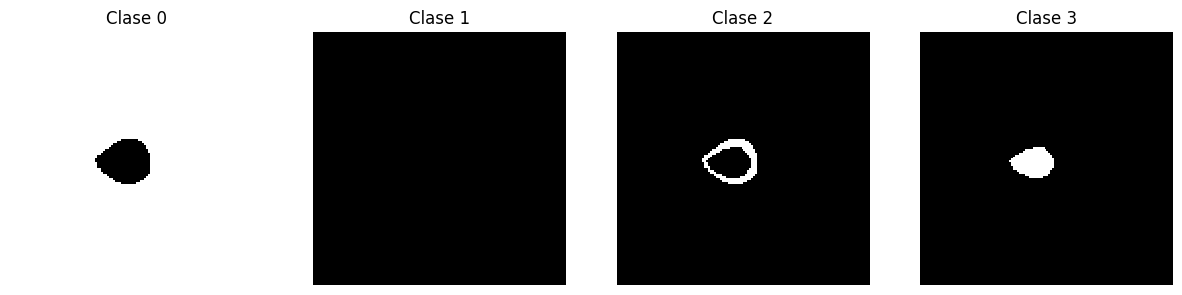

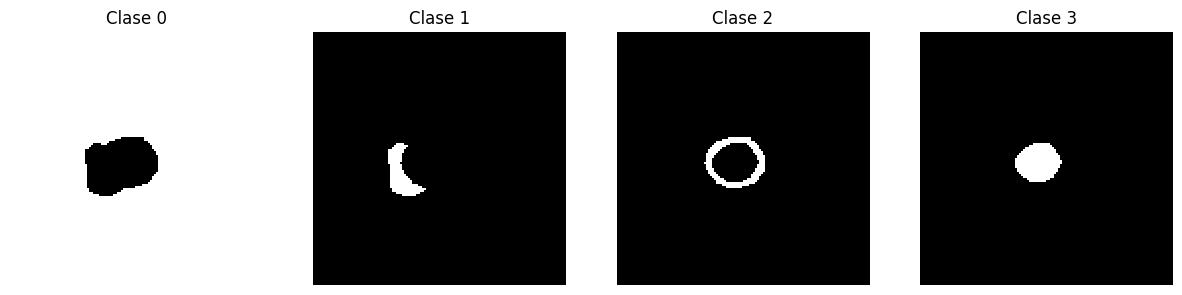

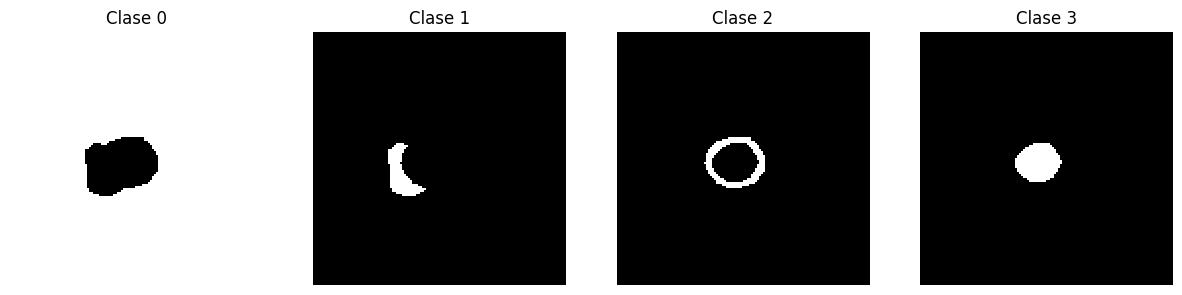

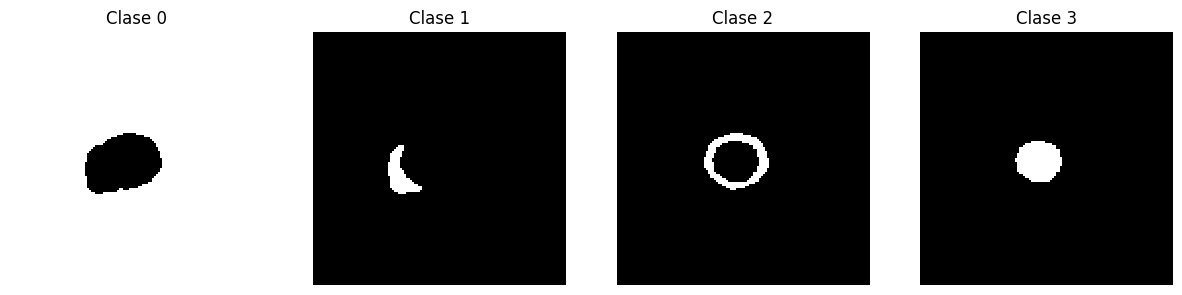

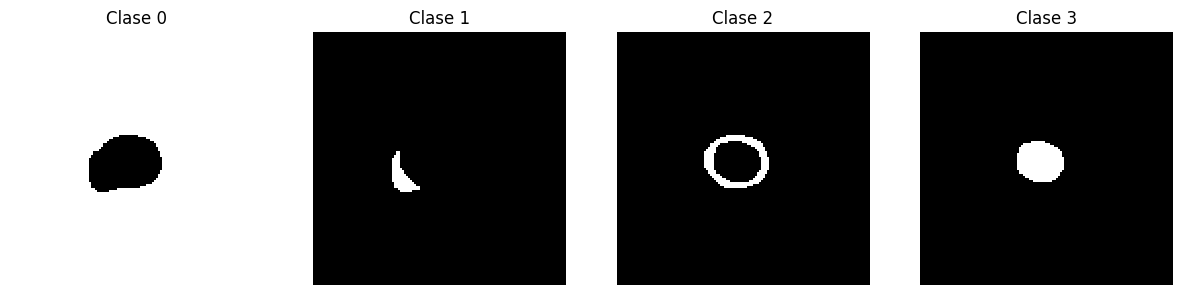

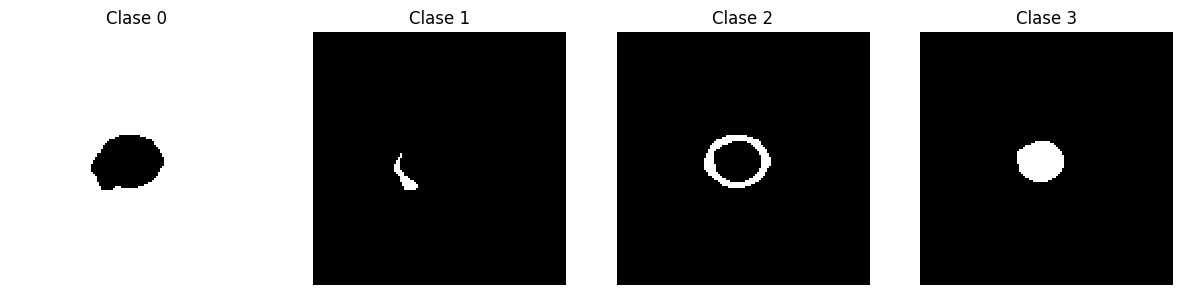

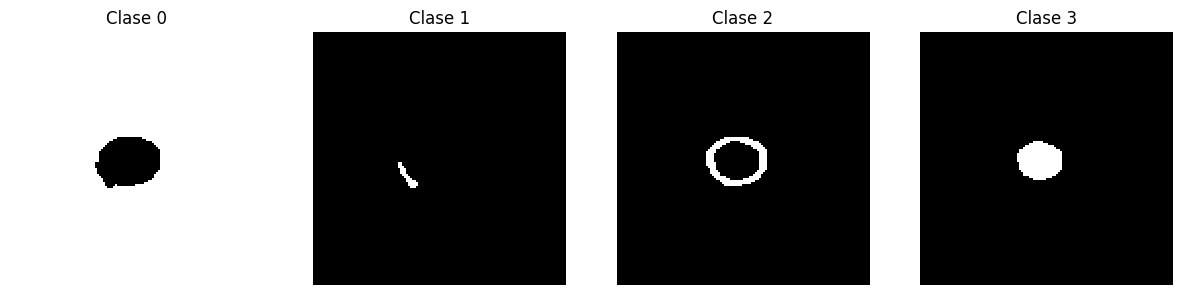

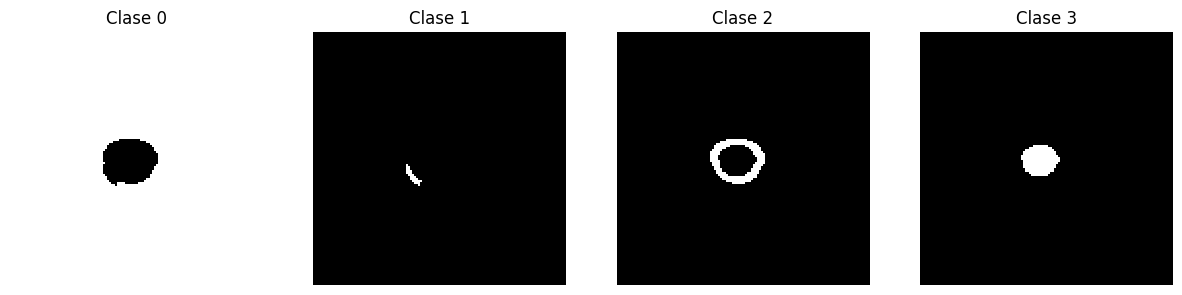

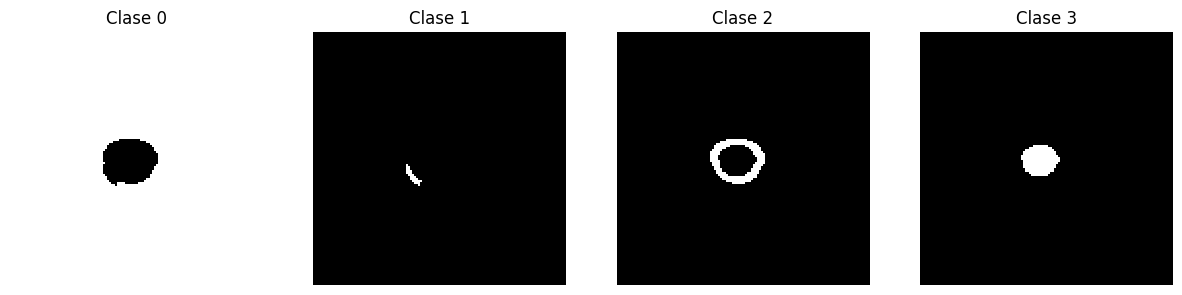

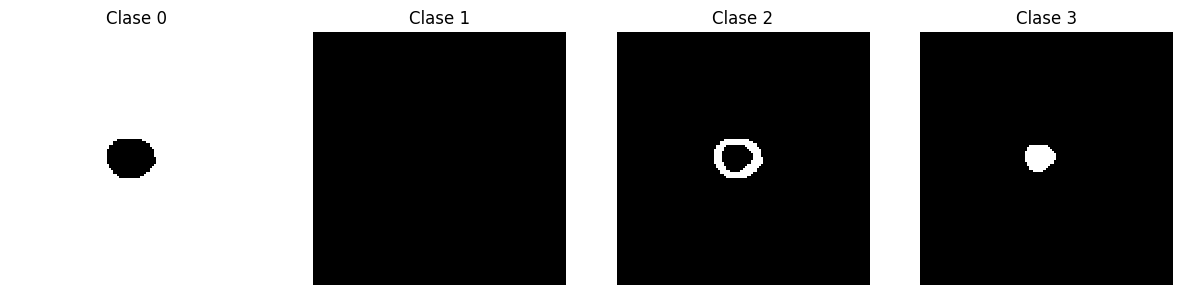

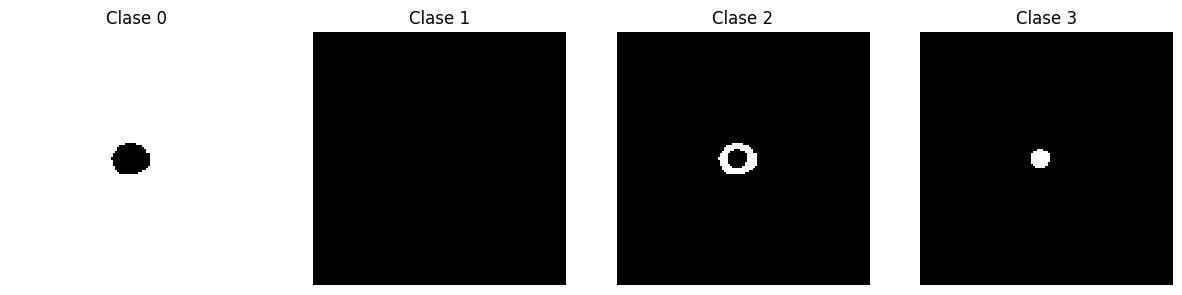

In [15]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

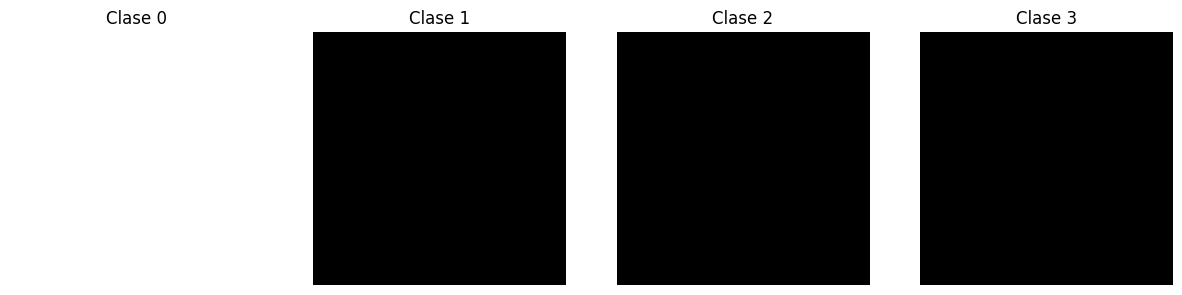

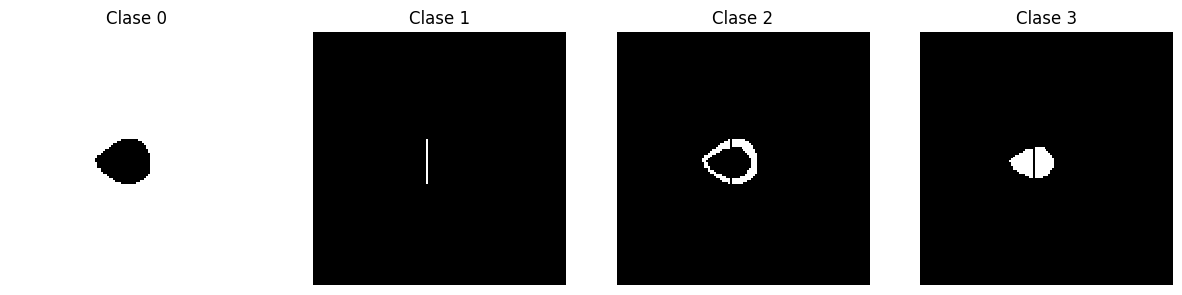

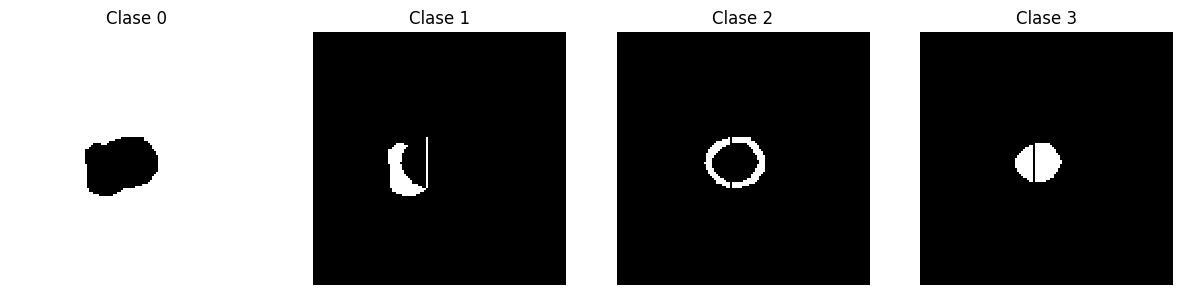

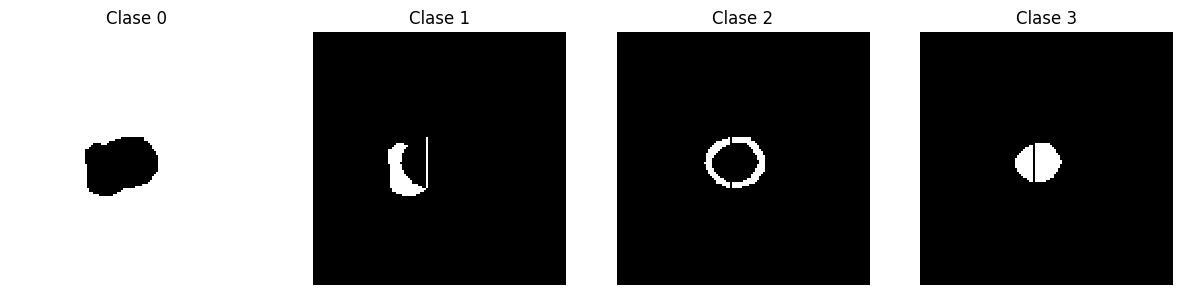

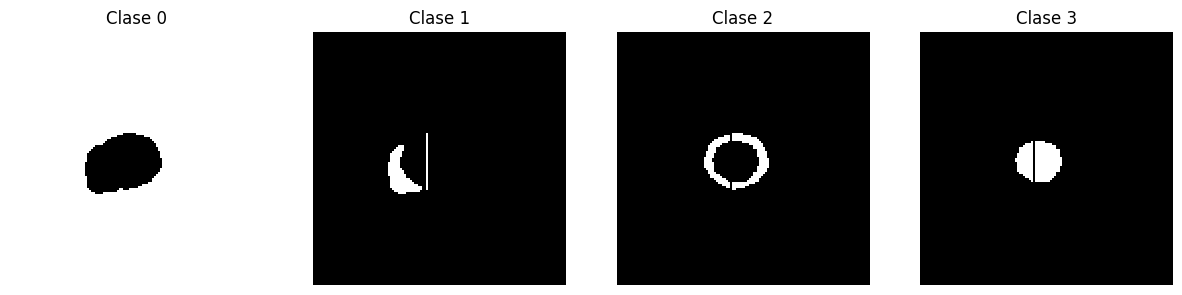

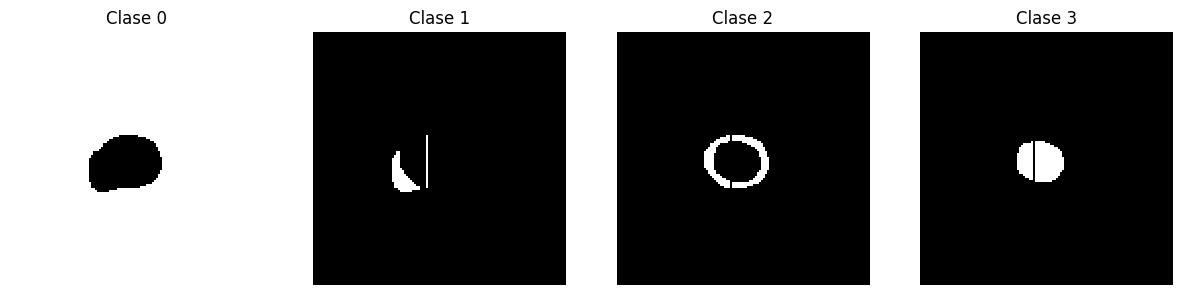

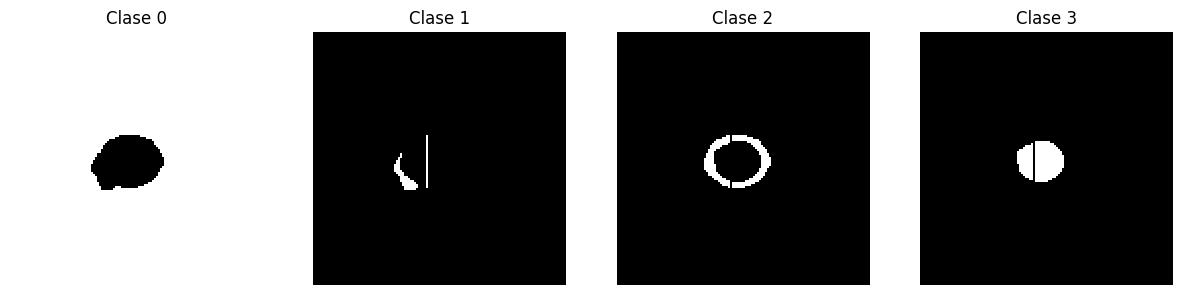

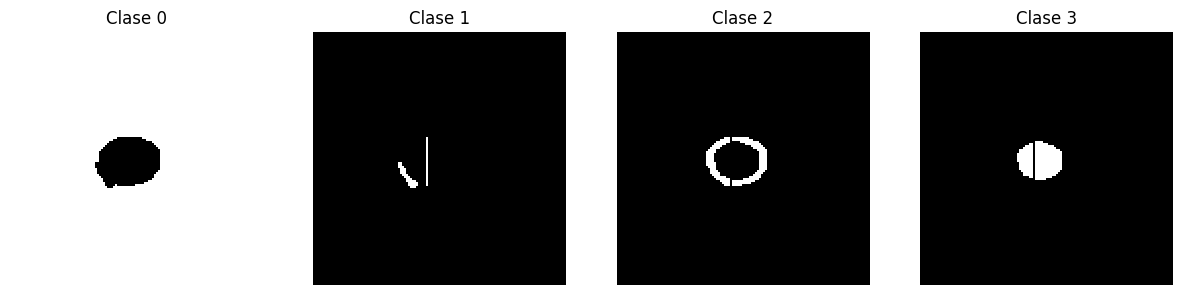

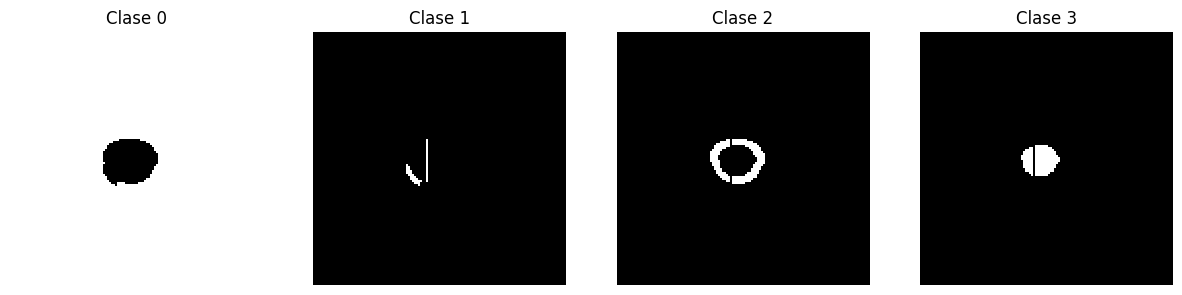

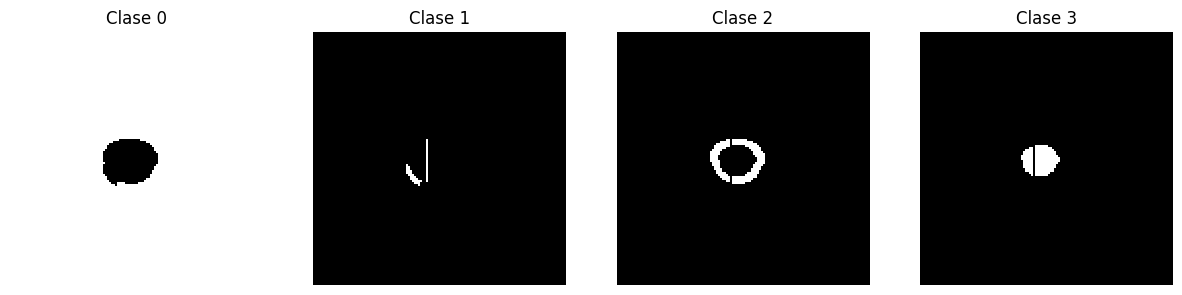

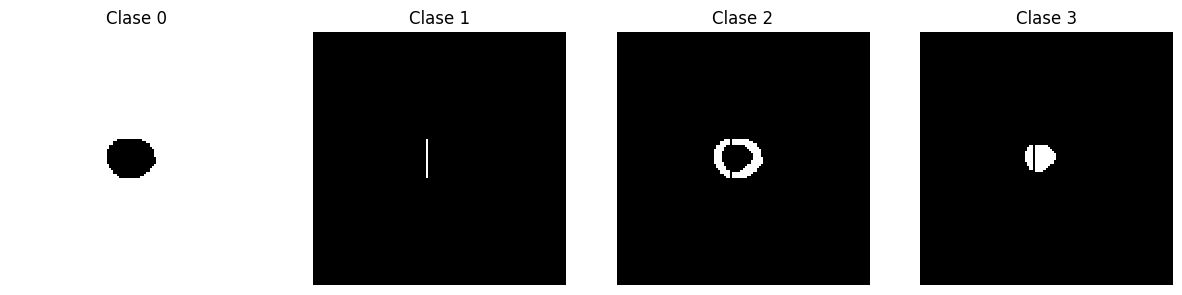

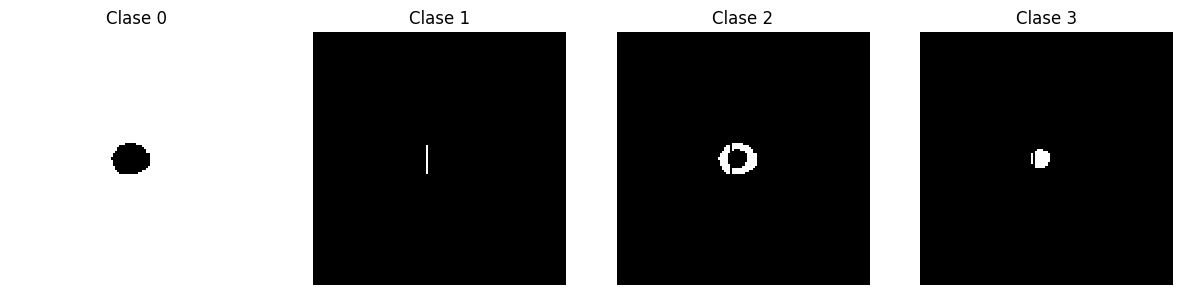

In [16]:
for j in range(12):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axs):
        ax.imshow(transform(train_data_dicts_noise)[0]['image'][i, j, :, :].numpy(), 
                  cmap='gray', interpolation='none', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f"Clase {i}")
    plt.show()

In [ ]:
# Crear un Dataset de MONAI para los archivos de entrenamiento y validación

train_data_dicts = [{"image": file} for file in training_files]
train_ds = Dataset(data=train_data_dicts, transform=all_transforms)

val_data_dicts = [{"image": file} for file in testing_files]
val_ds = Dataset(data=val_data_dicts, transform=all_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds[0]["image"].shape}')
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [ ]:
train_data_dicts_noise = [{"image": file} for file in training_files_noise]
train_ds_noise = Dataset(data=train_data_dicts_noise, transform=all_transforms)

val_data_dicts_noise = [{"image": file} for file in testing_files_noise]
val_ds_noise = Dataset(data=val_data_dicts_noise, transform=all_transforms)

train_loader_noise = DataLoader(train_ds_noise, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_noise[0]["image"].shape}')
val_loader_noise = DataLoader(val_ds_noise, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_noise[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [ ]:
train_data_dicts_elongated = [{"image": file} for file in training_files_elongated]
train_ds_elongated = Dataset(data=train_data_dicts_elongated, transform=all_transforms)

val_data_dicts_elongated = [{"image": file} for file in testing_files_elongated]
val_ds_elongated = Dataset(data=val_data_dicts_elongated, transform=all_transforms)

train_loader_elongated = DataLoader(train_ds_elongated, batch_size=1, shuffle=True, num_workers=1, persistent_workers=True)
print(f'Image shape {train_ds_elongated[0]["image"].shape}')
val_loader_elongated = DataLoader(val_ds_elongated, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
print(f'Image shape {val_ds_elongated[0]["image"].shape}')

Image shape torch.Size([4, 12, 128, 128])
Image shape torch.Size([4, 12, 128, 128])


In [20]:
# Get one batch of validation data to visualize
first(val_loader).__getitem__("image").shape
first(val_loader_noise).__getitem__("image").shape
first(val_loader_elongated).__getitem__("image").shape

torch.Size([1, 4, 12, 128, 128])

In [21]:
postprocess_transform = transforms.AsDiscreted(keys="image", argmax=True, dim=0)
postprocess_mask = postprocess_transform(val_ds[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask.shape[0]):
    plt.subplot(1, postprocess_mask.shape[1], i + 1)
    plt.imshow(postprocess_mask[i], cmap="gray", interpolation='none')
    plt.axis("off")

In [22]:
postprocess_mask_noise = postprocess_transform(val_ds_noise[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_noise.shape[0]):
    plt.subplot(1, postprocess_mask_noise.shape[1], i + 1)
    plt.imshow(postprocess_mask_noise[i], cmap="gray", interpolation='none')
    plt.axis("off")

In [23]:
postprocess_mask_elongated = postprocess_transform(val_ds_elongated[0])['image'][0]

plt.figure(figsize=(300, 50))
for i in range(postprocess_mask_elongated.shape[0]):
    plt.subplot(1, postprocess_mask_elongated.shape[1], i + 1)
    plt.imshow(postprocess_mask_elongated[i], cmap="gray", interpolation='none')
    plt.axis("off")

## Visualise examples from the training set

Imagen de entrenamiento cargada, tamaño: torch.Size([1, 4, 12, 128, 128])


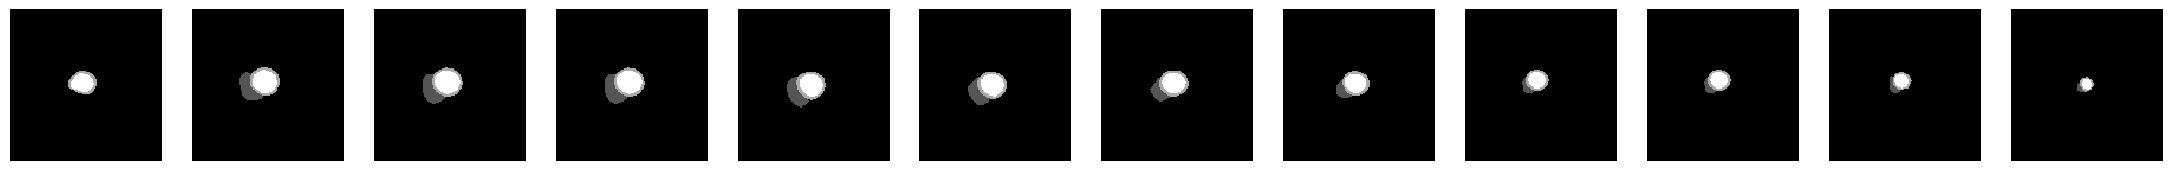

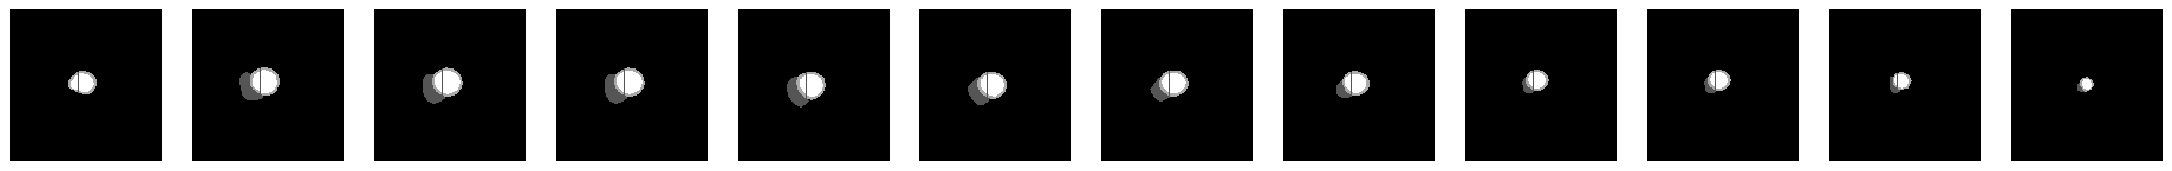

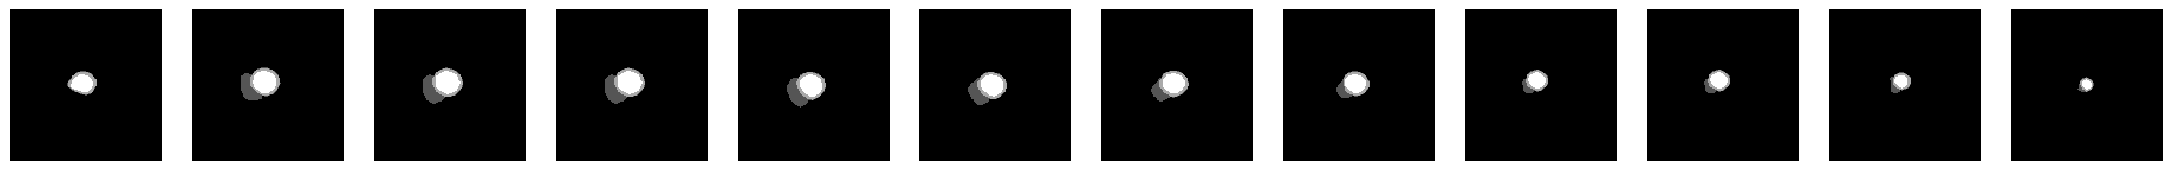

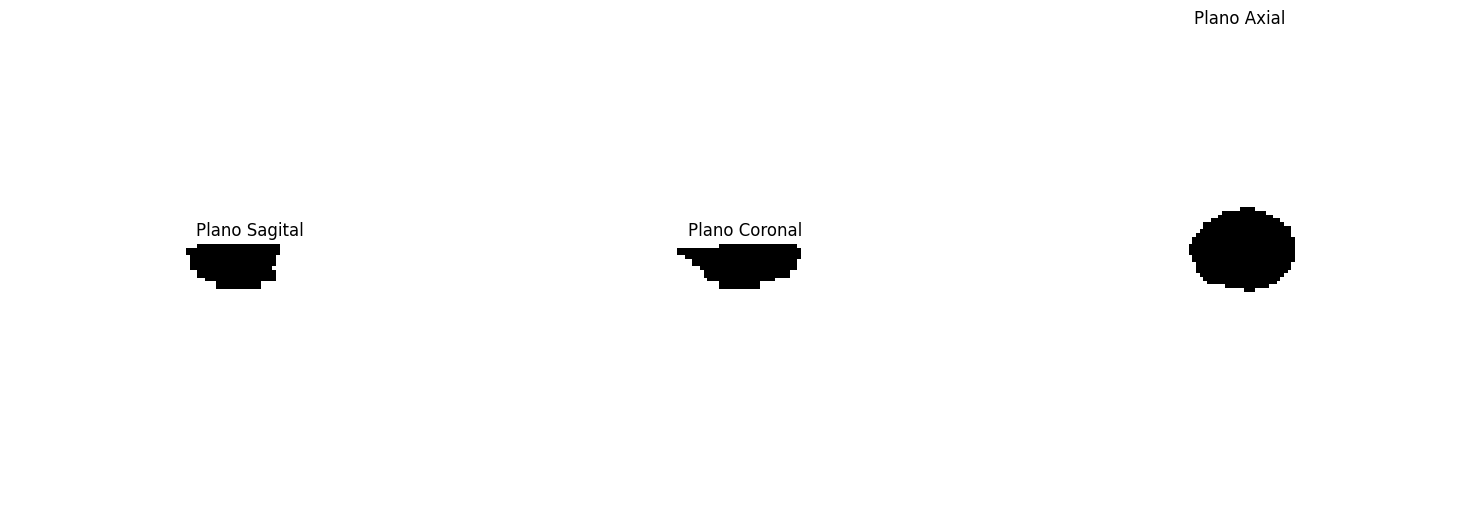

In [24]:
check_data = next(iter(train_loader))
image_tensor = check_data['image']  # Extrae la imagen como tensor

print(f"Imagen de entrenamiento cargada, tamaño: {image_tensor.shape}")


width_idx = image_tensor.size(4) // 2 # Sagittal
height_idx = image_tensor.size(3) // 2 # Coronal
depth_idx = image_tensor.size(2) // 2 # Axial

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plano sagital
image_slice_sagittal = image_tensor[0, 0, :, :, width_idx]
axs[0].imshow(image_slice_sagittal.cpu().numpy(), cmap='gray')
axs[0].set_title("Plano Sagital")
axs[0].axis('off')

# Plano coronal
image_slice_coronal = image_tensor[0, 0, :, height_idx, :]
axs[1].imshow(image_slice_coronal.cpu().numpy(), cmap='gray')
axs[1].set_title("Plano Coronal")
axs[1].axis('off')

# Plano axial
image_slice_axial = image_tensor[0, 0, depth_idx, :, :]
axs[2].imshow(image_slice_axial.cpu().numpy(), cmap='gray', interpolation='none')
axs[2].set_title("Plano Axial")
axs[2].axis('off')

plt.tight_layout()
plt.show()

Imagen de entrenamiento con ruido cargada, tamaño: torch.Size([1, 4, 12, 128, 128])


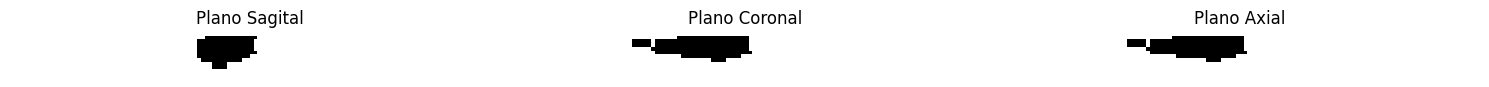

In [25]:
check_data_noise = next(iter(train_loader_noise))
image_tensor_noise = check_data_noise['image']  # Extrae la imagen como tensor

print(f"Imagen de entrenamiento con ruido cargada, tamaño: {image_tensor_noise.shape}")


width_idx = image_tensor_noise.size(4) // 2 # Sagittal
height_idx = image_tensor_noise.size(3) // 2 # Coronal
depth_idx = image_tensor_noise.size(2) // 2 # Axial

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plano sagital
image_slice_sagittal_noise = image_tensor_noise[0, 0, :, :, width_idx]
axs[0].imshow(image_slice_sagittal_noise.cpu().numpy(), cmap='gray')
axs[0].set_title("Plano Sagital")
axs[0].axis('off')

# Plano coronal
image_slice_coronal_noise = image_tensor_noise[0, 0, :, height_idx, :]
axs[1].imshow(image_slice_coronal_noise.cpu().numpy(), cmap='gray')
axs[1].set_title("Plano Coronal")
axs[1].axis('off')

# Plano axial
image_slice_axial_noise = image_tensor_noise[0, 0, depth_idx, :, :]
axs[2].imshow(image_slice_coronal_noise.cpu().numpy(), cmap='gray', interpolation='none')
axs[2].set_title("Plano Axial")
axs[2].axis('off')

plt.tight_layout()
plt.show()

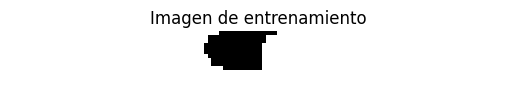

In [26]:
slice_idx = image_tensor.size(4) // 2
#image_slice = image_tensor[0, 0, :, :, slice_idx]
image_slice = image_tensor[0, :, :, :, slice_idx]

# Convertir el tensor en una imagen para visualizar con matplotlib
# plt.imshow(image_slice.cpu().numpy(), cmap='gray', interpolation='none')
plt.imshow(image_slice.permute(1, 2, 0).cpu().numpy(), interpolation='none')
plt.title("Imagen de entrenamiento")
plt.axis('off') 
plt.show()

Tamaño de la máscara cargada: torch.Size([1, 4, 12, 128, 128])
Representación one-hot generada correctamente. Visualizando cada voxel como un vector one-hot.


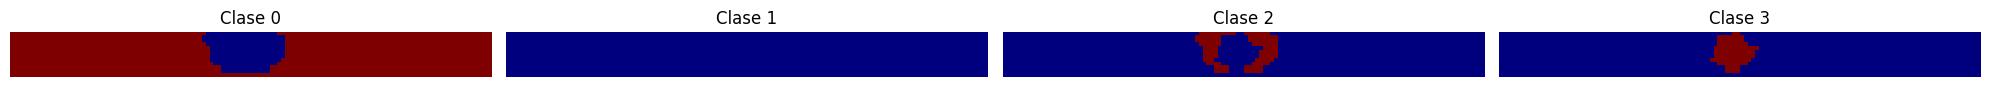

In [27]:
check_data = next(iter(train_loader)) 
image_tensor = check_data['image']

print(f"Tamaño de la máscara cargada: {image_tensor.shape}")

depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx]  # (batch, clases, ancho, alto, profundidad)

one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)

print("Representación one-hot generada correctamente. Visualizando cada voxel como un vector one-hot.")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4): 
    axs[i].imshow((one_hot_representation == i).astype(int), cmap="jet", vmin=0, vmax=1, interpolation='none')
    axs[i].set_title(f"Clase {i}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


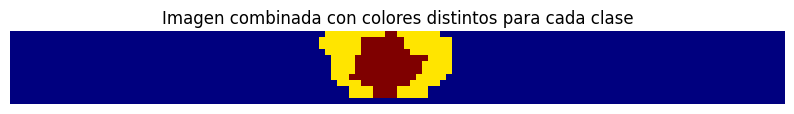

In [28]:
# slice axial del tensor de imagen
depth_idx = image_tensor.size(-1) // 2 
image_slice_axial = image_tensor[0, :, :, :, depth_idx]  # (batch, clases, ancho, alto, profundidad)

one_hot_representation = np.argmax(image_slice_axial.cpu().numpy(), axis=0)
combined_image = np.zeros_like(one_hot_representation, dtype=np.float32)

for i in range(4): 
    combined_image[one_hot_representation == i] = i / 3

plt.figure(figsize=(10, 8))
plt.imshow(combined_image, cmap="jet", vmin=0, vmax=1, interpolation='none')
plt.title("Imagen combinada con colores distintos para cada clase")
plt.axis("off")
plt.show()

## Define the network

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [30]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(

            # S1
            nn.Conv3d(4, 16, kernel_size=3, stride=(1,2,2), padding=1), # [4, 12, 128, 128] -> [16, 12, 64, 64]
            nn.BatchNorm3d(16),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            #S2
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1),      # [16, 12, 64, 64] -> [32, 6, 32, 32]
            nn.BatchNorm3d(32),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            #S3
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),      # [32, 6, 32, 32] -> [64, 3, 16, 16]
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            #S4
            nn.Conv3d(64, 1, kernel_size=3, stride=(1,2,2), padding=1),  # [64, 3, 16, 16] -> [1, 3, 8, 8]
            nn.BatchNorm3d(1),
            nn.ReLU(),
        )

        # Fully connected layer (Latent space)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 8 * 8, 64),
            nn.Linear(64, 3 * 8 * 8),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(

            #S4
            nn.ConvTranspose3d(1, 64, kernel_size=3, stride=(1,2,2), 
                               padding=1, output_padding=(0,1,1)),       # [1, 3, 8, 8] -> [64, 6, 16, 16]
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            #S3
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),            # [64, 3, 16, 16] -> [32, 6, 32, 32]
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            #S2
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=2, 
                               padding=1, output_padding=1),            # [32, 6, 32, 32] -> [16, 12, 64, 64]
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            #S1
            nn.ConvTranspose3d(16, 16, kernel_size=3, stride=(1,2,2), 
                               padding=1, output_padding=(0,1,1)),      # [16, 12, 64, 64] -> [16, 12, 128, 128]
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(16, 4, kernel_size=3, padding=1),                 # [16, 12, 128, 128] -> [4, 12, 128, 128]
        )

    # def forward(self, x):
    #     encoded = self.encoder(x) # [4, 12, 128, 128] -> [1, 3, 8, 8]
    #     latent_vector = self.fc(encoded.view(encoded.size(0), -1)) # [batch_size, 64]
    #     decoded = self.decoder(latent_vector.view(encoded.size()))
    #     return decoded, latent_vector
    
    def forward(self, x):
        # Encoder
        encoded = self.encoder(x)  # [batch_size, 1, 3, 8, 8]
        flattened = encoded.view(encoded.size(0), -1)  # Aplanamos el tensor
        latent_vector = self.fc[1](flattened)  # Extraemos el vector latente: nn.Linear(3 * 8 * 8, 64)
        fc_output = self.fc[2:](latent_vector)  # Pasamos el vector latente por las capas restantes

        # Decoder
        reshaped = fc_output.view(encoded.size())  # Ajustamos a la forma necesaria para el decoder
        decoded = self.decoder(reshaped)

        return decoded, latent_vector  # Devolvemos la salida decodificada y el vector latente
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
sample_input = torch.randn(1, 4, 12, 128, 128).to(device) 
sample_output = model(sample_input)[0]
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")
print(model) 

Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (11): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=Tru

In [31]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score

# Función dice_score
def dice_score(preds, targets, smooth=1e-6):
    preds = F.softmax(preds, dim=1)
    
    preds = preds[:, 1:, :, :, :]
    targets = targets[:, 1:, :, :, :]
    
    preds = torch.argmax(preds, dim=1)
    targets = torch.argmax(targets, dim=1)
    
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return dice.mean().item()

# Función de cálculo de MSE
def mse_score(preds, targets):
    preds = F.softmax(preds, dim=1)  
    preds = preds[:, 1:, :, :, :]
    targets = targets[:, 1:, :, :, :]
    
    mse = F.mse_loss(preds, targets, reduction='mean')
    return mse.item()

model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-6)
criterion = nn.CrossEntropyLoss() 

# Entrenamiento
num_epochs = 20
val_interval = 1
train_loss_list = []
val_loss_list = []
best_val_dice = 0
best_val_mse = float('inf') 
best_train_latent_vectors_dice = None
best_val_latent_vectors_dice = None
best_train_latent_vectors_mse = None
best_val_latent_vectors_mse = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for batch_data in tqdm(train_loader):
        inputs = batch_data["image"].to(device)
        outputs, train_latent_vectors_output = model(inputs)
        
        loss = criterion(outputs, F.interpolate(inputs, size=outputs.shape[2:], mode='nearest'))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')
    
    # Validación
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        val_dice = 0
        val_mse = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs = val_data["image"].to(device)
                val_outputs, val_latent_vectors_output = model(val_inputs)
                
                val_loss += criterion(val_outputs, F.interpolate(val_inputs, size=val_outputs.shape[2:], mode='nearest')).item()
                val_dice += dice_score(val_outputs, val_inputs)
                val_mse += mse_score(val_outputs, val_inputs)
        
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_mse = val_mse / len(val_loader)
        val_loss_list.append(avg_val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Dice: {avg_val_dice:.4f}, Validation MSE: {avg_val_mse:.4f}')
        
        # Guardar vectores latentes si el Dice score es el mejor
        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            best_train_latent_vectors_dice = []
            best_val_latent_vectors_dice = []
            
            with torch.no_grad():
                for batch_data in tqdm(train_loader, desc="Saving Best Train Latent Vectors (Dice)"):
                    inputs = batch_data["image"].to(device)
                    _, latent_vectors = model(inputs)
                    best_train_latent_vectors_dice.append(latent_vectors.detach().cpu().numpy())

                for val_data in tqdm(val_loader, desc="Saving Best Validation Latent Vectors (Dice)"):
                    val_inputs = val_data["image"].to(device)
                    _, latent_vectors = model(val_inputs)
                    best_val_latent_vectors_dice.append(latent_vectors.detach().cpu().numpy())
        
        # Guardar vectores latentes si el MSE es el menor
        if avg_val_mse < best_val_mse:
            best_val_mse = avg_val_mse
            best_train_latent_vectors_mse = []
            best_val_latent_vectors_mse = []
            
            with torch.no_grad():
                for batch_data in tqdm(train_loader, desc="Saving Best Train Latent Vectors (MSE)"):
                    inputs = batch_data["image"].to(device)
                    _, latent_vectors = model(inputs)
                    best_train_latent_vectors_mse.append(latent_vectors.detach().cpu().numpy())

                for val_data in tqdm(val_loader, desc="Saving Best Validation Latent Vectors (MSE)"):
                    val_inputs = val_data["image"].to(device)
                    _, latent_vectors = model(val_inputs)
                    best_val_latent_vectors_mse.append(latent_vectors.detach().cpu().numpy())

if best_train_latent_vectors_dice:
    best_train_latent_vectors_dice = np.concatenate(best_train_latent_vectors_dice, axis=0)
else:
    best_train_latent_vectors_dice = np.array([])

if best_val_latent_vectors_dice:
    best_val_latent_vectors_dice = np.concatenate(best_val_latent_vectors_dice, axis=0)
else:
    best_val_latent_vectors_dice = np.array([])

if best_train_latent_vectors_mse:
    best_train_latent_vectors_mse = np.concatenate(best_train_latent_vectors_mse, axis=0)
else:
    best_train_latent_vectors_mse = np.array([])

if best_val_latent_vectors_mse:
    best_val_latent_vectors_mse = np.concatenate(best_val_latent_vectors_mse, axis=0)
else:
    best_val_latent_vectors_mse = np.array([])

# Guardar los vectores latentes de la última época
last_train_latent_vectors = []
last_val_latent_vectors = []

model.eval()
with torch.no_grad():
    for batch_data in tqdm(train_loader, desc="Saving Train Latent Vectors (Last Epoch)"):
        inputs = batch_data["image"].to(device)
        _, latent_vectors = model(inputs)
        last_train_latent_vectors.append(latent_vectors.detach().cpu().numpy())

    for val_data in tqdm(val_loader, desc="Saving Validation Latent Vectors (Last Epoch)"):
        val_inputs = val_data["image"].to(device)
        _, latent_vectors = model(val_inputs)
        last_val_latent_vectors.append(latent_vectors.detach().cpu().numpy())

last_train_latent_vectors = np.concatenate(last_train_latent_vectors, axis=0)
last_val_latent_vectors = np.concatenate(last_val_latent_vectors, axis=0)

100%|██████████| 200/200 [00:11<00:00, 16.78it/s]


Epoch [1/20], Train Loss: 0.1444
Epoch [1/20], Validation Loss: 0.0975, Validation Dice: 0.0823, Validation MSE: 0.0103


100%|██████████| 200/200 [00:11<00:00, 17.01it/s]


Epoch [2/20], Train Loss: 0.0803
Epoch [2/20], Validation Loss: 0.0834, Validation Dice: 0.1790, Validation MSE: 0.0098


100%|██████████| 200/200 [00:11<00:00, 17.55it/s]


Epoch [3/20], Train Loss: 0.0727
Epoch [3/20], Validation Loss: 0.0764, Validation Dice: 0.0909, Validation MSE: 0.0092


100%|██████████| 200/200 [00:10<00:00, 19.08it/s]


Epoch [4/20], Train Loss: 0.0693
Epoch [4/20], Validation Loss: 0.0757, Validation Dice: 0.1284, Validation MSE: 0.0093


100%|██████████| 200/200 [00:09<00:00, 22.00it/s]


Epoch [5/20], Train Loss: 0.0644
Epoch [5/20], Validation Loss: 0.0782, Validation Dice: 0.1329, Validation MSE: 0.0089


100%|██████████| 200/200 [00:11<00:00, 17.87it/s]


Epoch [6/20], Train Loss: 0.0616
Epoch [6/20], Validation Loss: 0.0711, Validation Dice: 0.1552, Validation MSE: 0.0085


100%|██████████| 200/200 [00:10<00:00, 19.78it/s]


Epoch [7/20], Train Loss: 0.0549
Epoch [7/20], Validation Loss: 0.0656, Validation Dice: 0.2386, Validation MSE: 0.0079


100%|██████████| 200/200 [00:11<00:00, 17.94it/s]


Epoch [8/20], Train Loss: 0.0524
Epoch [8/20], Validation Loss: 0.0687, Validation Dice: 0.2582, Validation MSE: 0.0084


100%|██████████| 200/200 [00:11<00:00, 17.93it/s]


Epoch [9/20], Train Loss: 0.0495
Epoch [9/20], Validation Loss: 0.0605, Validation Dice: 0.2197, Validation MSE: 0.0073


100%|██████████| 200/200 [00:11<00:00, 18.17it/s]


Epoch [10/20], Train Loss: 0.0465
Epoch [10/20], Validation Loss: 0.0632, Validation Dice: 0.2693, Validation MSE: 0.0076


100%|██████████| 200/200 [00:10<00:00, 19.19it/s]


Epoch [11/20], Train Loss: 0.0459
Epoch [11/20], Validation Loss: 0.0605, Validation Dice: 0.2451, Validation MSE: 0.0071


100%|██████████| 200/200 [00:08<00:00, 23.03it/s]


Epoch [12/20], Train Loss: 0.0433
Epoch [12/20], Validation Loss: 0.0608, Validation Dice: 0.2499, Validation MSE: 0.0070


100%|██████████| 200/200 [00:08<00:00, 23.19it/s]


Epoch [13/20], Train Loss: 0.0417
Epoch [13/20], Validation Loss: 0.0702, Validation Dice: 0.2622, Validation MSE: 0.0082


100%|██████████| 200/200 [00:08<00:00, 23.17it/s]


Epoch [14/20], Train Loss: 0.0413
Epoch [14/20], Validation Loss: 0.0584, Validation Dice: 0.2786, Validation MSE: 0.0071


100%|██████████| 200/200 [00:10<00:00, 19.68it/s]


Epoch [15/20], Train Loss: 0.0399
Epoch [15/20], Validation Loss: 0.0577, Validation Dice: 0.2352, Validation MSE: 0.0067


100%|██████████| 200/200 [00:08<00:00, 23.08it/s]


Epoch [16/20], Train Loss: 0.0397
Epoch [16/20], Validation Loss: 0.0550, Validation Dice: 0.2696, Validation MSE: 0.0066


100%|██████████| 200/200 [00:08<00:00, 23.33it/s]


Epoch [17/20], Train Loss: 0.0382
Epoch [17/20], Validation Loss: 0.0661, Validation Dice: 0.2181, Validation MSE: 0.0070


100%|██████████| 200/200 [00:09<00:00, 21.92it/s]


Epoch [18/20], Train Loss: 0.0379
Epoch [18/20], Validation Loss: 0.0610, Validation Dice: 0.2256, Validation MSE: 0.0065


100%|██████████| 200/200 [00:08<00:00, 22.55it/s]


Epoch [19/20], Train Loss: 0.0370
Epoch [19/20], Validation Loss: 0.0549, Validation Dice: 0.2248, Validation MSE: 0.0065


100%|██████████| 200/200 [00:10<00:00, 18.86it/s]


Epoch [20/20], Train Loss: 0.0380
Epoch [20/20], Validation Loss: 0.0591, Validation Dice: 0.2564, Validation MSE: 0.0069


Saving Validation Latent Vectors (Last Epoch): 100%|██████████| 100/100 [00:04<00:00, 22.66it/s]


In [32]:
val_outputs.shape, val_inputs.shape

(torch.Size([1, 4, 12, 128, 128]), torch.Size([1, 4, 12, 128, 128]))

In [33]:
val_outputs[0,0,0,0,:]

metatensor([4.5908, 5.6118, 5.7174, 5.2203, 5.6080, 5.1959, 5.5825, 5.2427, 5.6072,
        5.1740, 5.5551, 5.2126, 5.5687, 5.1393, 5.5125, 5.1646, 5.5044, 5.0727,
        5.4692, 5.1512, 5.5284, 5.1128, 5.5237, 5.2133, 5.6120, 5.1929, 5.6095,
        5.2956, 5.7121, 5.2903, 5.6792, 5.3132, 5.7007, 5.2670, 5.6913, 5.3400,
        5.7619, 5.3353, 5.7347, 5.3180, 5.6797, 5.2285, 5.6729, 5.2961, 5.7048,
        5.2698, 5.6868, 5.2594, 5.5719, 5.0791, 5.5177, 5.1690, 5.5633, 5.1184,
        5.5588, 5.2202, 5.5830, 5.1091, 5.5199, 5.1927, 5.5856, 5.1549, 5.5753,
        5.2515, 5.6260, 5.1813, 5.5867, 5.2649, 5.6634, 5.2538, 5.6500, 5.3056,
        5.6696, 5.2378, 5.6166, 5.2643, 5.6400, 5.2293, 5.6130, 5.2556, 5.6071,
        5.1846, 5.5951, 5.2594, 5.6538, 5.2374, 5.6501, 5.2899, 5.6594, 5.2139,
        5.6317, 5.2738, 5.6646, 5.2253, 5.6227, 5.2277, 5.5602, 5.0912, 5.5184,
        5.1723, 5.5753, 5.1341, 5.5608, 5.1977, 5.5731, 5.1089, 5.5513, 5.2172,
        5.6374, 5.1931, 5.6203, 5.25

In [34]:
print(f"Train Latent Vector Shape (last epoch): {last_train_latent_vectors.shape}")
print(f"Train Latent Vector Shape (best epoch dice): {best_train_latent_vectors_dice.shape}")
print(f"Train Latent Vector Shape (best epoch mse): {best_train_latent_vectors_mse.shape}")
print(f"Validation Latent Vector Shape (last epoch): {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape (best epoch dice): {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape (best epoch dice): {best_val_latent_vectors_mse.shape}")
print(last_train_latent_vectors[0].shape)
print(last_val_latent_vectors[0].shape)
print(best_train_latent_vectors_dice[0].shape)
print(best_val_latent_vectors_dice[0].shape)
print(best_train_latent_vectors_mse[0].shape)
print(best_val_latent_vectors_mse[0].shape)

Train Latent Vector Shape (last epoch): (200, 64)
Train Latent Vector Shape (best epoch dice): (200, 64)
Train Latent Vector Shape (best epoch mse): (200, 64)
Validation Latent Vector Shape (last epoch): (100, 64)
Validation Latent Vector Shape (best epoch dice): (100, 64)
Validation Latent Vector Shape (best epoch dice): (100, 64)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)


In [35]:
# # Guardar los vectores latentes de la mejor época
# output_dir = '/mnt/nfs/home/liglesias'
# np.savetxt(os.path.join(output_dir, 'best_train_latent_vectors.tsv'), best_train_latent_vectors, delimiter='\t')
# np.savetxt(os.path.join(output_dir, 'best_val_latent_vectors.tsv'), best_val_latent_vectors, delimiter='\t')

# print(f"Vectores latentes de la mejor época guardados en {output_dir}")

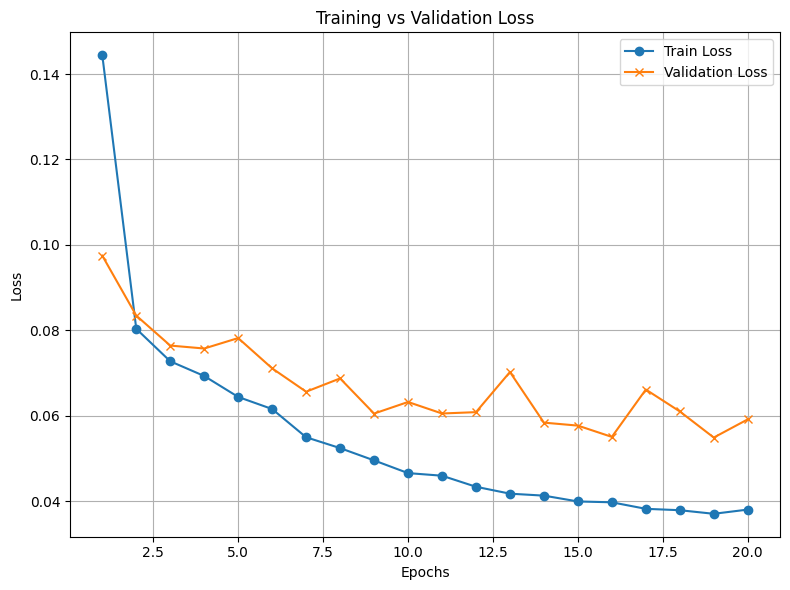

In [36]:
# Visualización de pérdidas
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_loss_list, label="Train Loss", marker='o')
val_epochs = list(range(val_interval, num_epochs + 1, val_interval))
plt.plot(val_epochs, val_loss_list, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
def visualize_axial_reconstruction(model, data_loader, device):
    postprocess_transform = transforms.AsDiscreted(keys="image", argmax=True, dim=1)

    model.eval()
    with torch.no_grad():
        batch_data = next(iter(data_loader))
        inputs = batch_data["image"].to(device)

        print(f"Min: {inputs.min()}, Max: {inputs.max()}, Mean: {inputs.mean()}, Std: {inputs.std()}")
        outputs, _ = model(inputs)

        postprocess_input = postprocess_transform({"image": inputs})["image"]
        postprocess_output = postprocess_transform({"image": outputs})["image"]

        print(f"Input shape: {inputs.shape}")
        print(f"Output shape: {outputs.shape}")
        print(f"Postprocess output shape: {postprocess_output.shape}")

        slice_idx = postprocess_output.shape[2] // 2  # Índice de la rebanada central
        
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(postprocess_input[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
        plt.title("Imagen Original")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(postprocess_output[0, 0, slice_idx].cpu().numpy(), cmap="gray", interpolation='none')
        plt.title("Reconstrucción")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

Min: 0.0, Max: 1.0, Mean: 0.25, Std: 0.4330129623413086
Input shape: torch.Size([1, 4, 12, 128, 128])
Output shape: torch.Size([1, 4, 12, 128, 128])
Postprocess output shape: torch.Size([1, 1, 12, 128, 128])


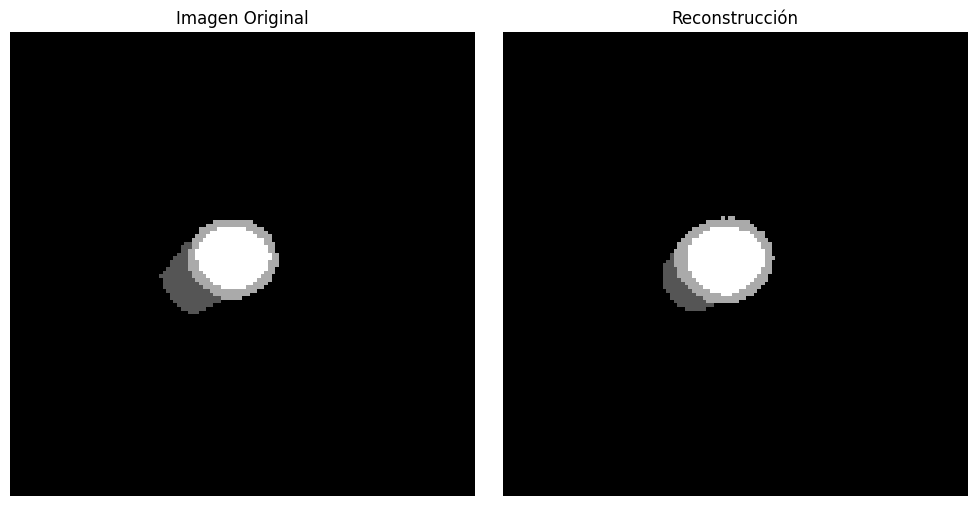

In [38]:
visualize_axial_reconstruction(model, val_loader, device)

In [39]:
torch.save(model.state_dict(), 'autoencoder_model.pth')

In [40]:
train_latent_vectors_noise = []
val_latent_vectors_noise = []

with torch.no_grad():
    for batch_data in tqdm(train_loader_noise, desc="Encoding Noisy Train Images"):
        noisy_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(noisy_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        train_latent_vectors_noise.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_noise, desc="Encoding Noisy Validation Images"):
        noisy_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(noisy_inputs) 

        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        val_latent_vectors_noise.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_noise = np.concatenate(train_latent_vectors_noise, axis=0)
val_latent_vectors_noise = np.concatenate(val_latent_vectors_noise, axis=0)  

print(f"Train Latent Vectors Shape (Noise): {train_latent_vectors_noise.shape}")
print(f"Validation Latent Vectors Shape (Noise): {val_latent_vectors_noise.shape}")
# print(f"Validation Latent Vectors (Noise): {val_latent_vectors_noise[0]}")

Encoding Noisy Validation Images: 100%|██████████| 100/100 [00:05<00:00, 18.87it/s]

Train Latent Vectors Shape (Noise): (200, 64)
Validation Latent Vectors Shape (Noise): (100, 64)


In [41]:
train_latent_vectors_elongated = []
val_latent_vectors_elongated = []

with torch.no_grad():
    for batch_data in tqdm(train_loader_elongated, desc="Encoding Elongated Train Images"):
        elongated_inputs = batch_data["image"].to(device) 
    
        encoded = model.encoder(elongated_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        train_latent_vectors_elongated.append(latent_vector.cpu().numpy())  

with torch.no_grad():
    for batch_data in tqdm(val_loader_elongated, desc="Encoding Elongated Validation Images"):
        elongated_inputs = batch_data["image"].to(device) 
        
        encoded = model.encoder(elongated_inputs) 
        flattened = encoded.view(encoded.size(0), -1) 
        latent_vector = model.fc[1](flattened)  # Pasar por la capa lineal nn.Linear(3 * 8 * 8, 64)
        val_latent_vectors_elongated.append(latent_vector.cpu().numpy())  
        
train_latent_vectors_elongated = np.concatenate(train_latent_vectors_elongated, axis=0)
val_latent_vectors_elongated = np.concatenate(val_latent_vectors_elongated, axis=0)  

print(f"Train Latent Vectors Shape (Elongation): {train_latent_vectors_elongated.shape}")
print(f"Validation Latent Vectors Shape (Elongation): {val_latent_vectors_elongated.shape}")
# print(f"Validation Latent Vectors (Elongation): {val_latent_vectors_noise[0]}")

Encoding Elongated Validation Images: 100%|██████████| 100/100 [00:07<00:00, 13.45it/s]

Train Latent Vectors Shape (Elongation): (200, 64)
Validation Latent Vectors Shape (Elongation): (100, 64)


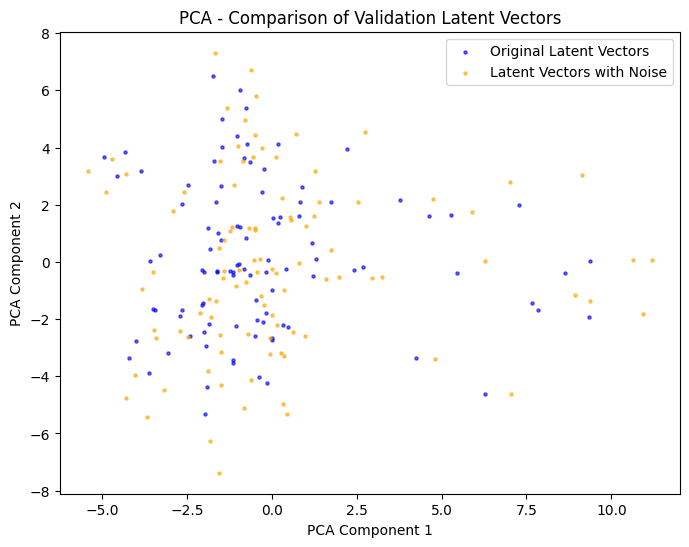

In [42]:
from sklearn.decomposition import PCA
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_noise], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_mse, val_latent_vectors_noise], axis=0)

pca = PCA(n_components=2)
all_val_latent_vectors_pca = pca.fit_transform(all_val_latent_vectors)
all_val_latent_vectors_pca.shape

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_pca[:100, 0], all_val_latent_vectors_pca[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_pca[100:, 0], all_val_latent_vectors_pca[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('PCA - Comparison of Validation Latent Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

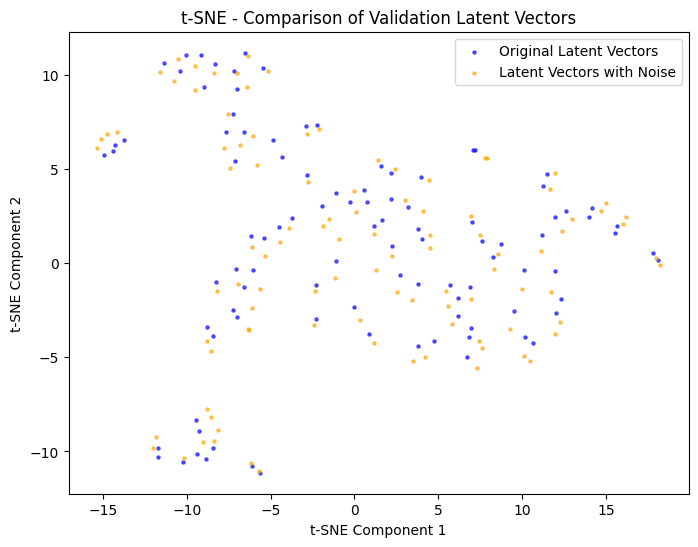

In [43]:
# Usando t-sne
from sklearn.manifold import TSNE
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_noise], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_mse, val_latent_vectors_noise], axis=0)

tsne = TSNE(n_components=2, random_state=42)
all_val_latent_vectors_tsne = tsne.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_tsne[:100, 0], all_val_latent_vectors_tsne[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_tsne[100:, 0], all_val_latent_vectors_tsne[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('t-SNE - Comparison of Validation Latent Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


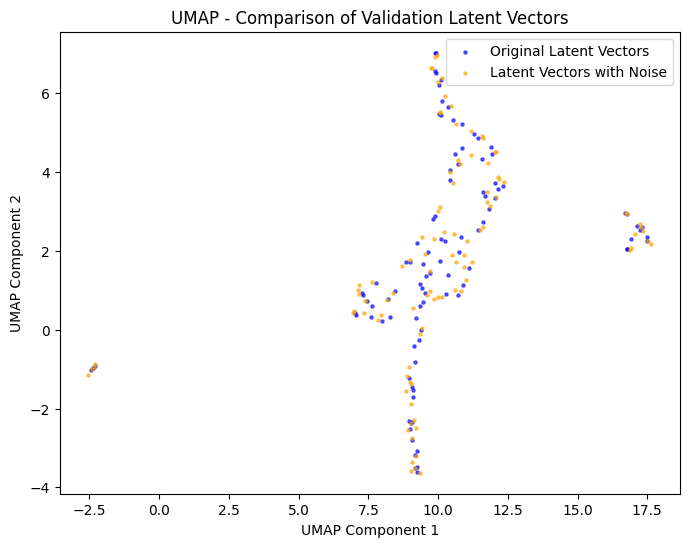

In [44]:
# Usando UMAP
import umap
# all_val_latent_vectors = np.concatenate([last_val_latent_vectors, val_latent_vectors_noise], axis=0)
all_val_latent_vectors = np.concatenate([best_val_latent_vectors_dice, val_latent_vectors_noise], axis=0)
# all_val_latent_vectors = np.concatenate([best_val_latent_vectors_mse, val_latent_vectors_noise], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=42)
all_val_latent_vectors_umap = umap_reducer.fit_transform(all_val_latent_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(all_val_latent_vectors_umap[:100, 0], all_val_latent_vectors_umap[:100, 1], s=5, c='blue', alpha=0.6, label='Original Latent Vectors')
plt.scatter(all_val_latent_vectors_umap[100:, 0], all_val_latent_vectors_umap[100:, 1], s=5, c='orange', alpha=0.6, label='Latent Vectors with Noise')
plt.title('UMAP - Comparison of Validation Latent Vectors')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

EUCLIDEAN DISTANCE

In [45]:
# Euclidean distances between the latent vectors of the last epoch and the latent vectors with noise

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_noise.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_noise[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_noise.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_noise, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.43526685 0.42094603 0.10113341 0.24040215 0.20687099 0.1928913
 0.7538889  0.27885768 0.40236756 0.2516401  0.20778368 0.53929543
 0.14733078 0.22075501 0.33529726 0.09319345 0.48580462 0.08877804
 0.44261366 0.0978124  0.6433257  0.509605   0.6491556  0.20457387
 0.5825916  0.57849437 0.4403608  0.49989533 0.5502818  0.16000463
 0.44084552 0.33615294 0.9313029  0.32584754 0.43558756 0.15668543
 0.38461468 0.29298213 0.1929338  0.15365888 0.4811366  0.06268352
 0.49686438 0.62632    0.4910174  0.11721945 0.43107975 0.10611857
 0.4420386  0.10402103 0.11611009 0.07504142 0.16289333 0.41619077
 0.22245562 0.43046594 0.19151218 0.35319647 0.61274177 0.42130712
 0.45357177 0.1699124  0.23343638 0.20129545 0.24907605 0.6330573
 0.33843696 0.07420058 0.5480005  0.5223458  0.54233533 0.5044582
 0.6531336  0.21768638 0.18927972 0.3228154  0.8687602  0.45754328
 0.013

In [46]:
# Euclidean distance between the latent vectors of the last epoch and the latent vectors with elongation

print(f"Validation Latent Vector Shape: {last_val_latent_vectors.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_elongated.shape}")

print(last_val_latent_vectors[0].shape)
print(val_latent_vectors_elongated[0].shape)

assert last_val_latent_vectors.shape == val_latent_vectors_elongated.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [0.26517817 0.24165641 0.196694   0.13294448 0.26710898 0.30091393
 0.30926982 0.25293183 0.2544915  0.1864749  0.22591205 0.23603205
 0.29811257 0.22561073 0.27444017 0.2071305  0.4164074  0.38198134
 0.28584    0.22750562 0.29206482 0.2125107  0.35870236 0.37190422
 0.38161922 0.33868605 0.29032668 0.22442818 0.34240946 0.28431252
 0.3843897  0.26036513 0.46304193 0.4562009  0.30981073 0.3432374
 0.29801676 0.30107918 0.323178   0.2714507  0.32020462 0.28926918
 0.38679466 0.34735912 0.43899015 0.30855098 0.37139374 0.39621586
 0.26429674 0.17945763 0.25564107 0.22545893 0.42710432 0.47394457
 0.4677969  0.3581461  0.34848642 0.28979912 0.32113293 0.29760522
 0.3406952  0.31146467 0.33619025 0.35280085 0.2845608  0.27822196
 0.21776931 0.1550417  0.21803974 0.20535836 0.3833395  0.35506877
 0.27619725 0.24100527 0.21789192 0.16323078 0.46683675 0.42684266
 0.3



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



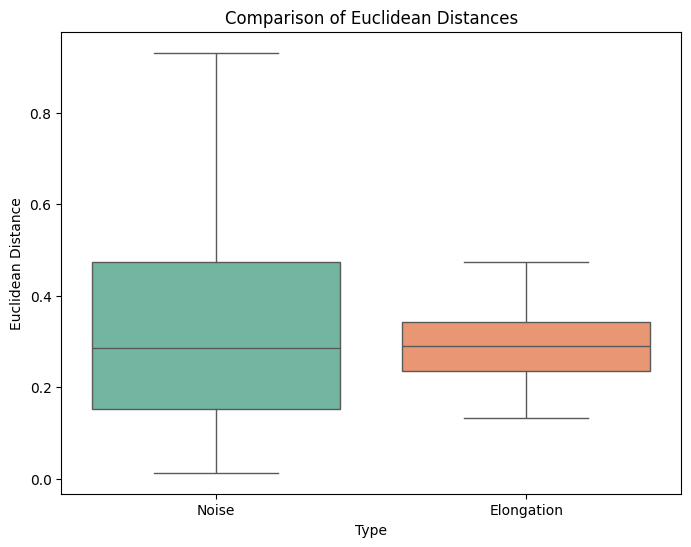

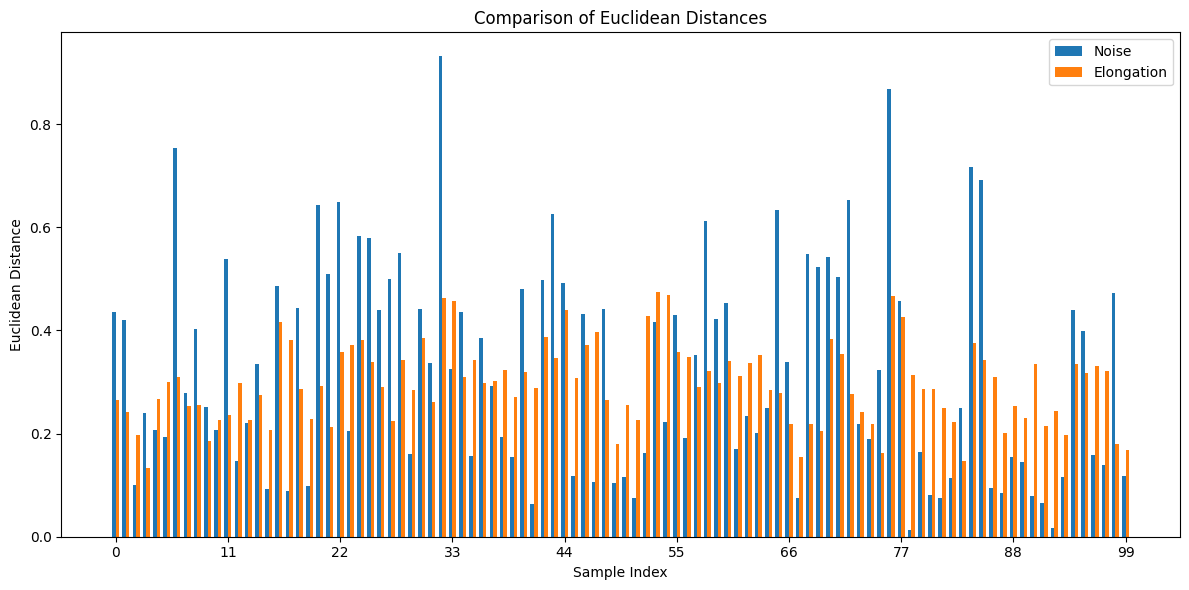

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

euclidean_distances_noise = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_noise, axis=1)
euclidean_distances_elongated = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_noise) + list(euclidean_distances_elongated),
    'Type': ['Noise'] * len(euclidean_distances_noise) + ['Elongation'] * len(euclidean_distances_elongated)
})

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette="Set2")
plt.title("Comparison of Euclidean Distances")
plt.ylabel("Euclidean Distance")
plt.show()
x = np.arange(len(euclidean_distances_noise))

width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise, width, label='Noise')
rects2 = ax.bar(x + width/2, euclidean_distances_elongated, width, label='Elongation')

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances')
ax.legend()

ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))

plt.tight_layout()
plt.show()

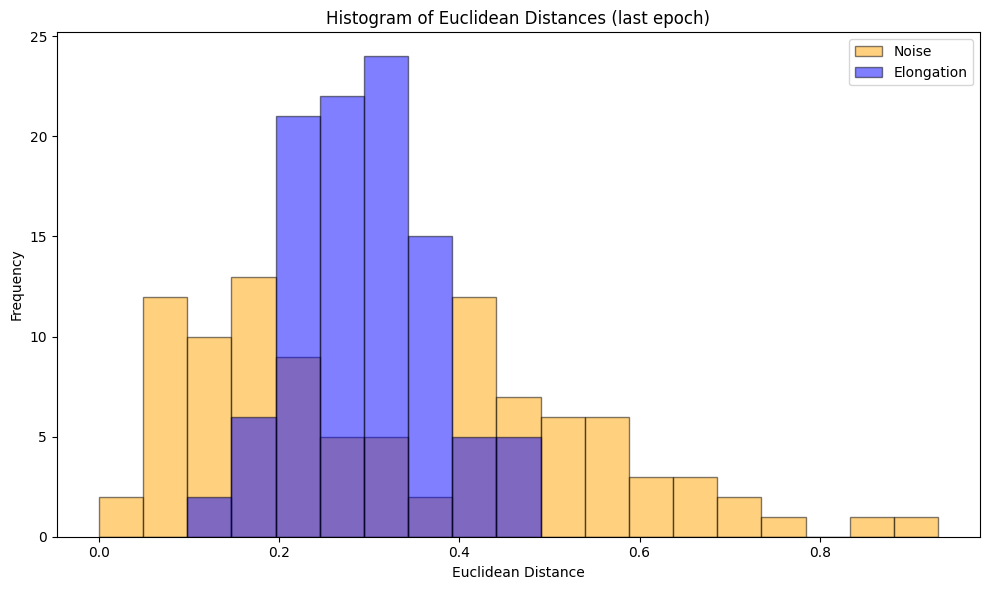

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Definir los intervalos (bins)
bins = np.linspace(0, max(np.max(euclidean_distances_noise), np.max(euclidean_distances_elongated)), 20)

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise, bins=bins, alpha=0.5, label='Noise', color='orange', edgecolor='black')
plt.hist(euclidean_distances_elongated, bins=bins, alpha=0.5, label='Elongation', color='blue', edgecolor='black')

# Configurar etiquetas y leyenda
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances (last epoch)')
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

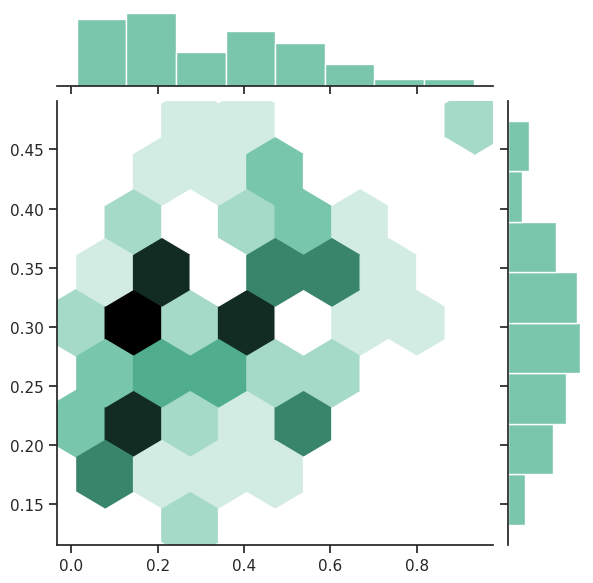

In [59]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

x = euclidean_distances_noise
y = euclidean_distances_elongated

sns.set_theme(style="ticks")

sns.jointplot(x=x, y=y, kind="hex", color="#4CB391")
plt.show()

In [48]:
# Euclidean distance between the latent vectors of the best epoch (Dice) and the latent vectors with noise

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_noise.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_noise[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_noise.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_noise, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [1.3189445  1.209383   1.0275203  0.76934177 1.8719605  1.8214647
 1.5377755  1.0689347  1.6274234  1.1389085  2.0269446  2.035178
 1.323375   0.8783777  1.362915   1.0947026  3.550971   2.923294
 1.2026017  0.9525034  1.453422   0.9120405  2.793959   2.691584
 2.461236   2.1614192  1.7770267  1.3080295  1.3410125  1.2500051
 1.228769   0.8991468  3.2625403  3.0023754  1.6498774  1.4038377
 2.1459806  1.4511496  1.2814435  1.0842574  2.1988616  1.4257903
 1.4643801  1.2612636  1.6055015  1.1013561  2.2696087  1.9137008
 1.277379   0.9070288  1.4802363  0.9380526  2.277632   1.5887299
 1.663779   1.1606827  1.9877409  1.3976543  2.0548844  1.4589425
 2.0746827  1.9063462  1.8993366  1.8032253  2.1855836  1.8393042
 1.969514   1.698135   1.287741   1.0426978  2.2253034  1.887396
 2.7566216  2.260048   1.5416107  1.2698972  1.9022032  1.4134083
 2.0682158  1.748998

In [49]:
# Euclidean distance between the latent vectors of the best epoch (dice) and the latent vectors with elongation

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_dice.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_elongated.shape}")

print(best_val_latent_vectors_dice[0].shape)
print(val_latent_vectors_elongated[0].shape)

assert best_val_latent_vectors_dice.shape == val_latent_vectors_elongated.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [1.2653866  1.1908939  0.9963532  0.7496221  1.8681546  1.8112048
 1.5482509  1.0208524  1.451963   1.0740671  1.9754858  1.8774371
 1.3577152  0.91023165 1.359917   1.0426813  3.5030766  2.6609585
 1.2189852  0.90035105 1.5711879  0.87781847 2.9803557  2.5572572
 2.3619666  2.1218383  1.8154633  1.3251084  1.4461488  1.2304265
 1.229191   0.8982698  3.5698364  2.9638817  1.665942   1.4393246
 1.9246042  1.2742574  1.3057297  1.0996221  2.0663095  1.2888829
 1.4528562  1.2642984  1.5674535  0.997496   2.2504842  1.7170715
 1.3711402  0.91740566 1.3537512  0.910133   2.0435073  1.4269694
 1.5362022  1.1491894  1.8395451  1.2663528  2.1895626  1.4914387
 2.180112   1.924655   1.9355932  1.8564352  2.217717   2.0315678
 1.8294883  1.6273248  1.2688626  1.1551291  2.5125225  2.1580038
 2.8936954  2.223916   1.498952   1.189627   2.0338144  1.39943
 1.9237273  1.5883



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



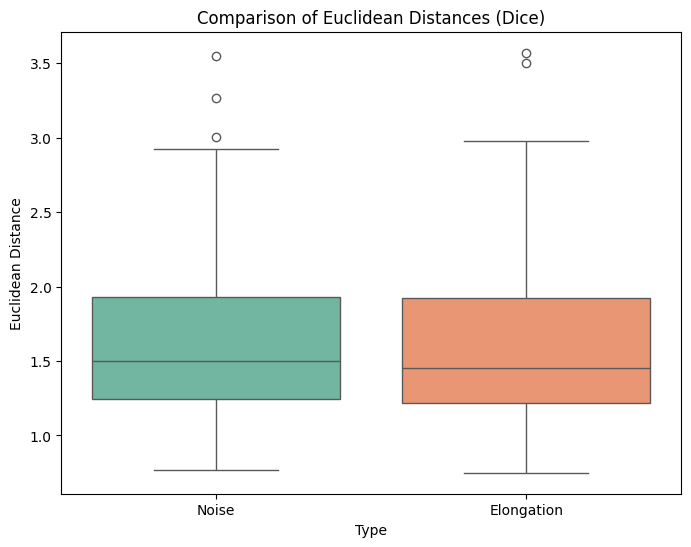

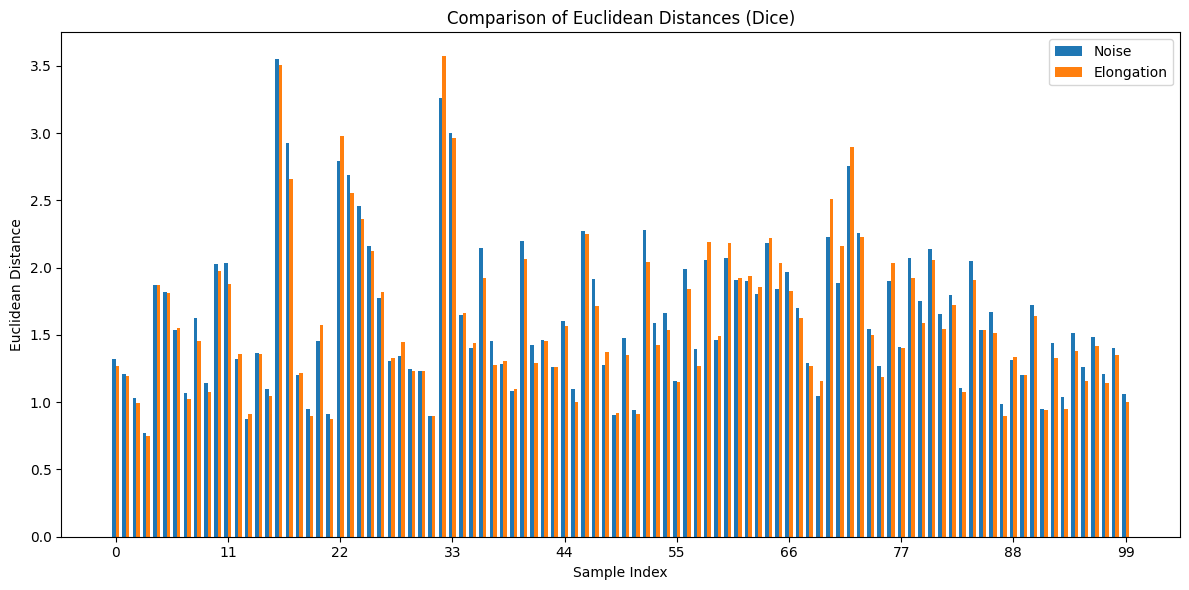

In [50]:
euclidean_distances_noise_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_noise, axis=1)
euclidean_distances_elongated_dice = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_noise_dice) + list(euclidean_distances_elongated_dice),
    'Type': ['Noise'] * len(euclidean_distances_noise_dice) + ['Elongation'] * len(euclidean_distances_elongated_dice)
})

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette="Set2")
plt.title("Comparison of Euclidean Distances (Dice)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_noise_dice))

width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_dice, width, label='Noise')
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_dice, width, label='Elongation')

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (Dice)')
ax.legend()

ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))

plt.tight_layout()
plt.show()

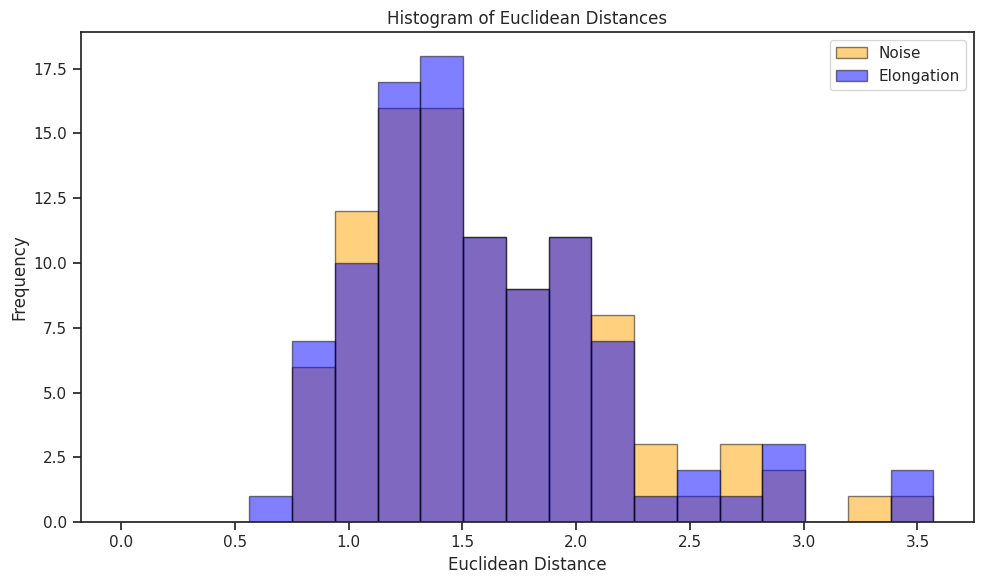

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Definir los intervalos (bins)
bins_dice = np.linspace(0, max(np.max(euclidean_distances_noise_dice), np.max(euclidean_distances_elongated_dice)), 20)

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise_dice, bins=bins_dice, alpha=0.5, label='Noise', color='orange', edgecolor='black')
plt.hist(euclidean_distances_elongated_dice, bins=bins_dice, alpha=0.5, label='Elongation', color='blue', edgecolor='black')

# Configurar etiquetas y leyenda
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

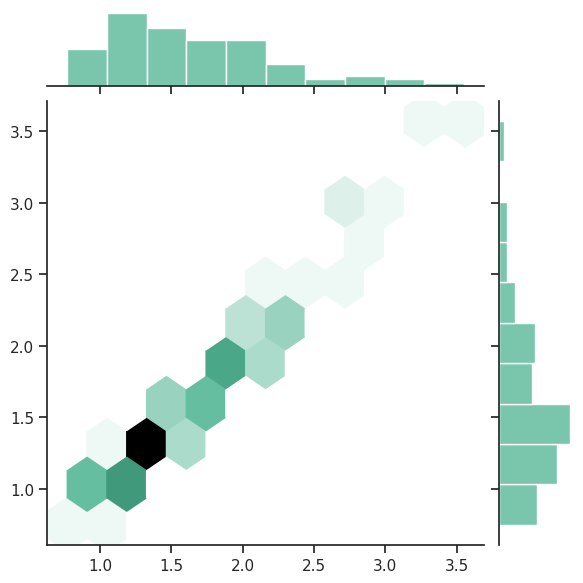

In [63]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

x_dice = euclidean_distances_noise_dice
y_dice = euclidean_distances_elongated_dice

sns.set_theme(style="ticks")

sns.jointplot(x=x_dice, y=y_dice, kind="hex", color="#4CB391")
plt.show()

In [51]:
# Euclidean distance between the latent vectors of the best epoch (mse) and the latent vectors with noise

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_mse.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_noise.shape}")

print(best_val_latent_vectors_mse[0].shape)
print(val_latent_vectors_noise[0].shape)

assert best_val_latent_vectors_mse.shape == val_latent_vectors_noise.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_noise, axis=1)

print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
Distancias Euclidianas: [1.2016479  1.2961386  1.0828408  1.0089183  1.7419573  1.7187726
 1.5430715  1.289631   1.6448022  1.1873097  1.3432299  1.3710724
 1.0632273  0.94532645 1.159772   0.99702567 1.8987942  1.667308
 1.1462625  0.99066514 1.4171764  1.228044   2.656559   2.0553749
 1.4094613  1.3268869  1.3442698  1.1768478  1.3876961  1.1775877
 1.3032874  1.1398544  2.6097245  2.167567   1.1230191  0.91278887
 1.1445316  1.1087985  1.1714721  1.0759354  1.2587793  0.9215889
 1.6572627  1.5362127  1.5137495  1.2001458  1.0730984  0.86639965
 1.2150956  0.95992726 1.0942447  1.0233963  2.0105572  1.6183108
 1.6290201  1.3302248  1.7246519  1.3578423  1.4825988  1.1747149
 1.27294    1.157433   1.1767067  1.1416171  1.3407491  1.3262491
 1.3667421  1.295796   1.2511737  1.2339678  0.99927104 0.9113182
 2.2348008  1.748542   1.3193891  1.1356075  1.8278135  1.3086034
 1.2420014  1.1

In [52]:
# Euclidean distance between the latent vectors of the best epoch (mse) and the latent vectors with elongation

print(f"Validation Latent Vector Shape: {best_val_latent_vectors_mse.shape}")
print(f"Validation Latent Vector Shape Noise: {val_latent_vectors_elongated.shape}")

print(best_val_latent_vectors_mse[0].shape)
print(val_latent_vectors_elongated[0].shape)

assert best_val_latent_vectors_mse.shape == val_latent_vectors_elongated.shape, "Las matrices deben tener la misma forma"

distancias_euclidianas = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_elongated, axis=1)

print(len(distancias_euclidianas))
print(f'Distancias Euclidianas: {distancias_euclidianas}')

Validation Latent Vector Shape: (100, 64)
Validation Latent Vector Shape Noise: (100, 64)
(64,)
(64,)
100
Distancias Euclidianas: [1.0996531  1.1662855  1.04079    0.95212185 1.6888508  1.6895474
 1.4029844  1.236744   1.4660778  1.136132   1.292969   1.3008133
 1.0477663  0.9344351  1.1110122  0.96073085 1.9673052  1.5791204
 1.0953251  0.9806325  1.3156499  1.0846609  2.568208   1.9160659
 1.3690909  1.2831823  1.2727898  1.0716064  1.2353735  1.1573722
 1.2465379  1.0985978  2.3958235  1.9807645  1.0856256  0.9719739
 1.1501412  1.098781   1.1210757  1.0352008  1.1945001  0.9038991
 1.5296979  1.3194586  1.4314029  1.2031059  1.0621527  0.75372267
 1.1264917  0.93588334 1.0088116  1.0096954  2.0301883  1.6521443
 1.60715    1.2576019  1.7727292  1.3833454  1.3076197  1.0829474
 1.1974112  1.1373246  1.2131566  1.209513   1.2930423  1.2922767
 1.2933149  1.2834865  1.1919078  1.2132697  1.0878767  0.97165185
 2.1184826  1.6662158  1.2621406  1.0768727  1.4672875  1.2041223
 1.2493528



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



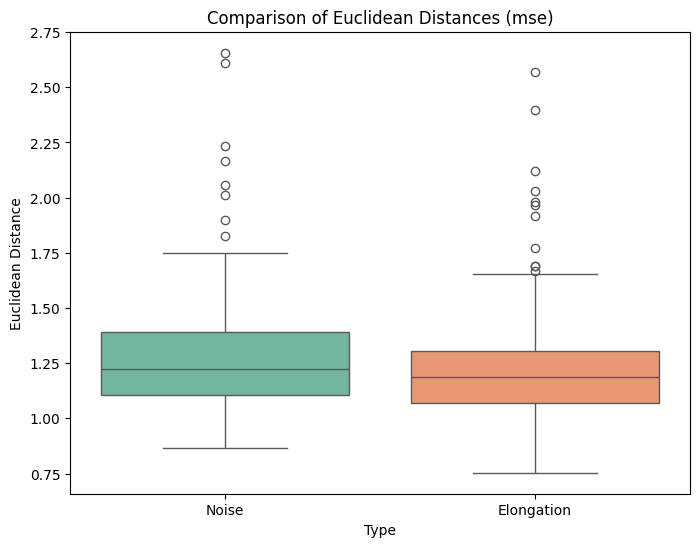

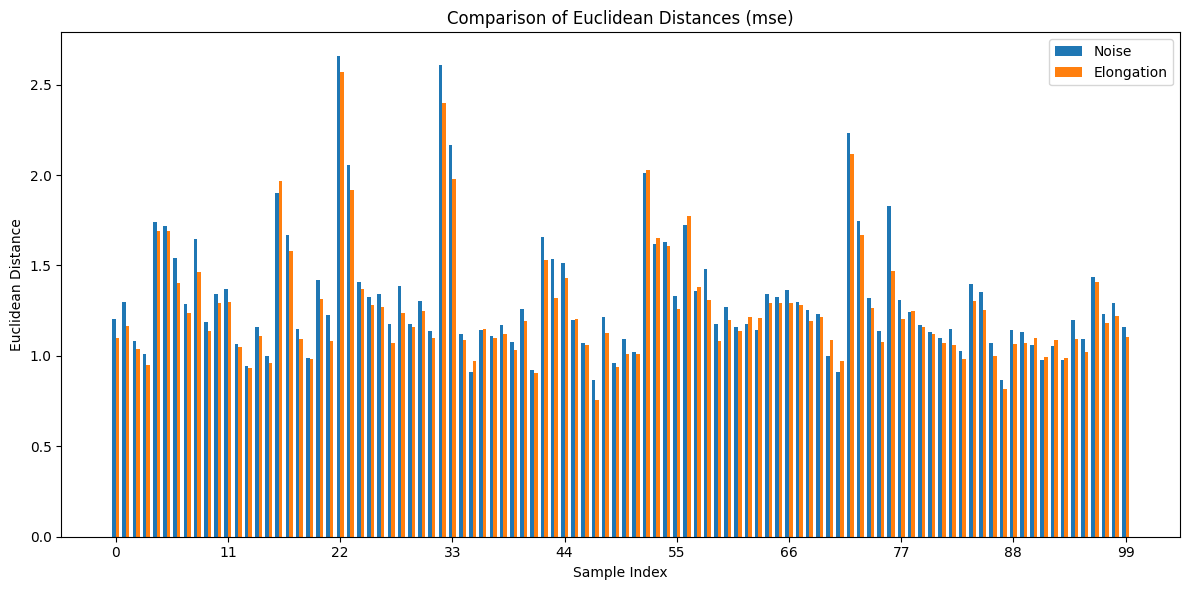

In [53]:
euclidean_distances_noise_mse = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_noise, axis=1)
euclidean_distances_elongated_mse = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': list(euclidean_distances_noise_mse) + list(euclidean_distances_elongated_mse),
    'Type': ['Noise'] * len(euclidean_distances_noise_mse) + ['Elongation'] * len(euclidean_distances_elongated_mse)
})

plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Distance', data=df, palette="Set2")
plt.title("Comparison of Euclidean Distances (mse)")
plt.ylabel("Euclidean Distance")
plt.show()

x = np.arange(len(euclidean_distances_noise_mse))

width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, euclidean_distances_noise_mse, width, label='Noise')
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_mse, width, label='Elongation')

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (mse)')
ax.legend()

ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))  
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))

plt.tight_layout()
plt.show()

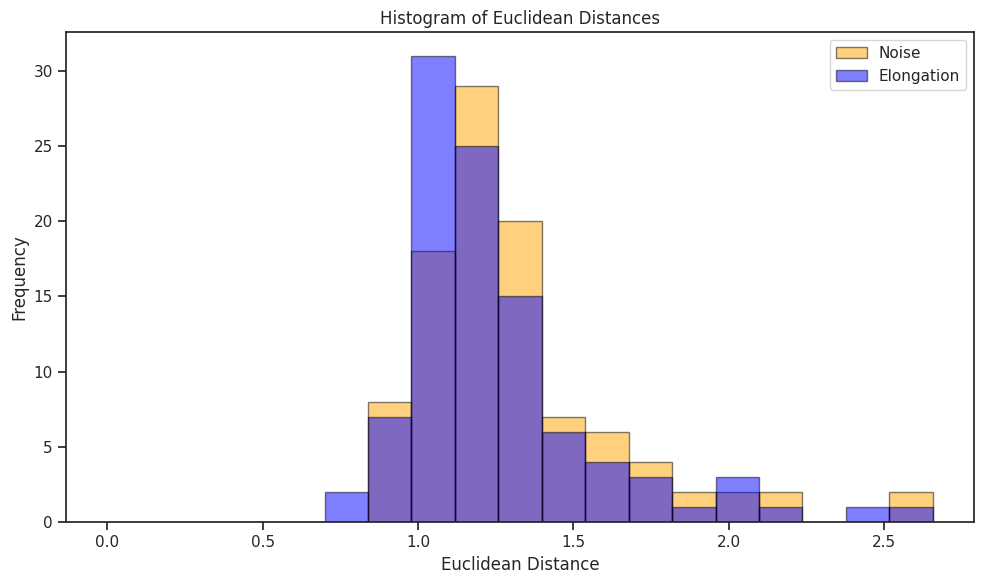

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Definir los intervalos (bins)
bins_mse = np.linspace(0, max(np.max(euclidean_distances_noise_mse), np.max(euclidean_distances_elongated_mse)), 20)

# Crear el histograma
plt.figure(figsize=(10, 6))
plt.hist(euclidean_distances_noise_mse, bins=bins_mse, alpha=0.5, label='Noise', color='orange', edgecolor='black')
plt.hist(euclidean_distances_elongated_mse, bins=bins_mse, alpha=0.5, label='Elongation', color='blue', edgecolor='black')

# Configurar etiquetas y leyenda
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Euclidean Distances')
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

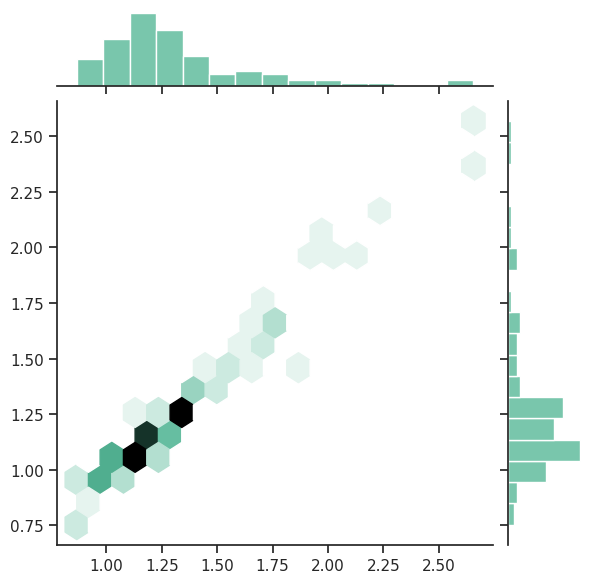

In [65]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

x_mse= euclidean_distances_noise_mse
y_mse = euclidean_distances_elongated_mse

sns.set_theme(style="ticks")

sns.jointplot(x=x_mse, y=y_mse, kind="hex", color="#4CB391")
plt.show()

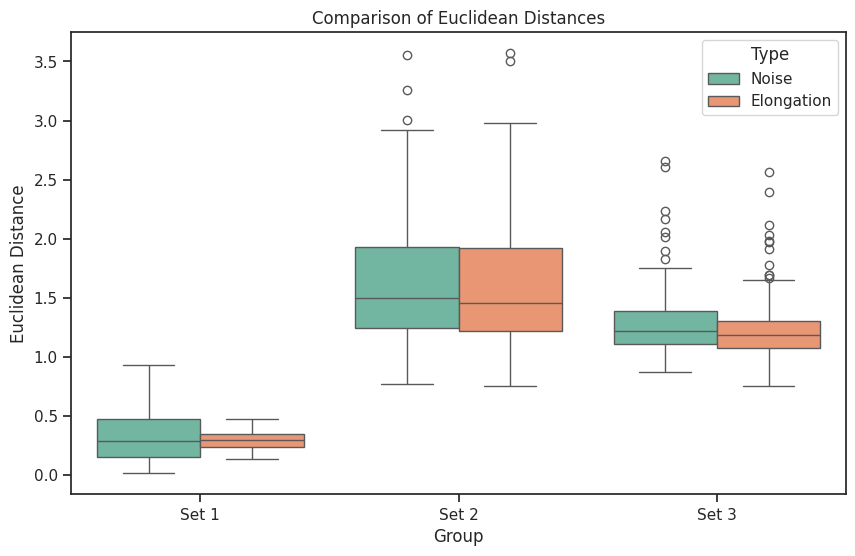

In [67]:
distances_noise_1 = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_noise, axis=1)
distances_elongation_1 = np.linalg.norm(last_val_latent_vectors - val_latent_vectors_elongated, axis=1)

distances_noise_2 = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_noise, axis=1)
distances_elongation_2 = np.linalg.norm(best_val_latent_vectors_dice - val_latent_vectors_elongated, axis=1)

distances_noise_3 = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_noise, axis=1)
distances_elongation_3 = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_elongated, axis=1)

df = pd.DataFrame({
    'Distance': (
        list(distances_noise_1) + list(distances_elongation_1) +
        list(distances_noise_2) + list(distances_elongation_2) +
        list(distances_noise_3) + list(distances_elongation_3)
    ),
    'Type': (
        ['Noise'] * len(distances_noise_1) + ['Elongation'] * len(distances_elongation_1) +
        ['Noise'] * len(distances_noise_2) + ['Elongation'] * len(distances_elongation_2) +
        ['Noise'] * len(distances_noise_3) + ['Elongation'] * len(distances_elongation_3)
    ),
    'Group': (
        ['Set 1'] * (len(distances_noise_1) + len(distances_elongation_1)) +
        ['Set 2'] * (len(distances_noise_2) + len(distances_elongation_2)) +
        ['Set 3'] * (len(distances_noise_3) + len(distances_elongation_3))
    )
})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Distance', hue='Type', data=df, palette="Set2")

plt.title("Comparison of Euclidean Distances")
plt.ylabel("Euclidean Distance")

plt.show()

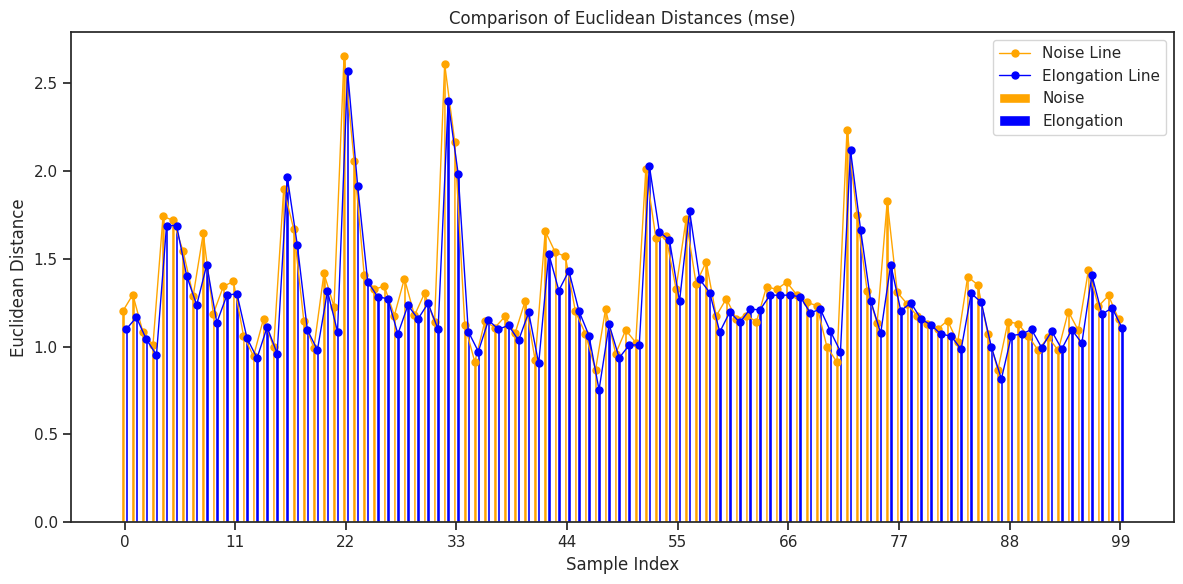

In [68]:
euclidean_distances_noise_mse = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_noise, axis=1)
euclidean_distances_elongated_mse = np.linalg.norm(best_val_latent_vectors_mse - val_latent_vectors_elongated, axis=1)

x = np.arange(len(euclidean_distances_noise_mse))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width/2, euclidean_distances_noise_mse, width, label='Noise', color='orange')
rects2 = ax.bar(x + width/2, euclidean_distances_elongated_mse, width, label='Elongation', color='blue')

ax.plot(x - width/2, euclidean_distances_noise_mse, color='orange', linewidth=1, marker='o', markersize=5, label='Noise Line')
ax.plot(x + width/2, euclidean_distances_elongated_mse, color='blue', linewidth=1, marker='o', markersize=5, label='Elongation Line')

ax.set_xlabel('Sample Index')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Comparison of Euclidean Distances (mse)')
ax.legend()

ax.set_xticks(np.linspace(0, len(x) - 1, num=10, dtype=int))
ax.set_xticklabels(np.linspace(0, len(x) - 1, num=10, dtype=int))

plt.tight_layout()
plt.show()

Files TSV

In [56]:
# train_latent_vectors_array = np.concatenate((best_train_latent_vectors, train_latent_vectors_noise), axis=0)
# val_latent_vectors_array = np.concatenate((best_val_latent_vectors, val_latent_vectors_noise), axis=0)

# print(f"Shape of train_latent_vectors_array: {train_latent_vectors_array.shape}")
# print(f"Shape of val_latent_vectors_array: {val_latent_vectors_array.shape}")

# if len(train_latent_vectors_array.shape) == 1:
#     train_latent_vectors_array = train_latent_vectors_array.reshape(-1, 1)
# if len(val_latent_vectors_array.shape) == 1:
#     val_latent_vectors_array = val_latent_vectors_array.reshape(-1, 1)

# output_dir = '/mnt/nfs/home/liglesias'
# np.savetxt(os.path.join(output_dir, 'train_latent_vectors.tsv'), train_latent_vectors_array, delimiter='\t')
# np.savetxt(os.path.join(output_dir, 'val_latent_vectors.tsv'), val_latent_vectors_array, delimiter='\t')

# print(f"Vectores latentes guardados en {output_dir}")

In [57]:
# import os
# import pandas as pd

# output_dir = '/mnt/nfs/home/liglesias'
# val_latent_vectors_df = pd.read_csv(os.path.join(output_dir, 'val_latent_vectors.tsv'), sep='\t', header=None)
# print(f"Shape of val_latent_vectors_df: {val_latent_vectors_df.shape}")

# val_latent_vectors_original_df = val_latent_vectors_df.iloc[:100]
# val_latent_vectors_noise_df = val_latent_vectors_df.iloc[-100:]

# num_original = len(val_latent_vectors_original_df)
# num_noise = len(val_latent_vectors_noise_df)

# metadata = {
#     'ID': list(range(1, num_original + num_noise + 1)),
#     'Type': ['Original'] * num_original + ['Noise'] * num_noise
# }
# metadata_df = pd.DataFrame(metadata)

# metadata_df.to_csv(os.path.join(output_dir, 'metadata.tsv'), sep='\t', index=False)

# print(f"Archivo de metadatos guardado en {output_dir}/metadata.tsv")